# Observational evidence for flow-dependent Stanon Numbers below Fimbulisen 

# In the following, we will explore the relation between melt rates and ocean properties and evaluate different methods to parameterize the observed melt rates as a function of U & T

After reading the data, we start by **fitting the 3-eqn. formulation, searching for an optimal constant $\Gamma_T$-value**. For this, we take Jenkin's drag coefficient and *assume a constant $\Gamma_T$/$\Gamma_S$ ratio of 30*; overall the solutions are rather insensitive of these choices, but it quickly turns out that no satisfying fit can be found, UNLESS:

- assuming a large offset in the observed melt rates (observations ~ 0.4m/yr too high), or, 
- assuming a large offset in the observed temperatures (observations ~ 0.15 degC too cold)!

Both of these solutions are not really satisfying, because we can have faith in our observations to be more precise than that. Even though individual strain rate estimates may have an error of 0.5 m/yr, the large number of observations should substantially reduce the error of the mean unless there are any systematic errors that make the uncertainty of the measurement one-sided (which we have discussed and could not see any evidence for). Likewise, for the ocean observations, we know that the observations taken 30 m below the ice base only roughly represent the properties at the outer part of the ice shelf ocean boundary layer (ISOBL), but under the most plausible cases, one would expect temperatures to decrease close to the ice base, rather than to increase (as would be needed to match the parameterization)--and with Stanton numbers (transfer coefficients or friction coefficient), that are about an order of magnitude smaller than what Jenkins et al. 2010 found below FIRS, as will be shown shortly. So, while these optimizations can reproduce the melt rate variability, we do not trust the physics that they would represent. Anyway, this is an important exploration/reference that should be discussed in the paper.

Therefore, we also compare the 3-eqn. formulation to a **purely empirical regression with either linear or non-linear influence of thermal driving and the free flow velocity**, as well as an **piecewise optimized fit of the 3eqn. formulation** with for *varying $\Gamma_T$-values*. The latter method gives as good as a result as any other, with plausible systematic variations as function of the of thermal driving and the free flow velocity (or melt rate), which can easily be understood as a transition between different melting regimes described in this paper: https://journals.ametsoc.org/view/journals/phoc/52/10/JPO-D-21-0317.1.xml (see their Table 4 and Fig. 11 for more details).

<u> A quick word about strain rates </u>:  
In all this analysis, I have used the constant mean strain rate, as it generally provides a better fit with the data than using the linear strain (or even time-varying ones), which reduces both the correlation between the time series (as shown and discussed earlier) and the fit of all of the below methods. Looking closely at the residuals (green curves in the time series below) of the parameterized minus observed melt rates, one can see that they have a slight slope, indicating that there might be a trend in the melt rates that is not captured. In fact, using a constant strain, one gets a slight upward trend in melt rates, while ocean properties woudl suggest a slight downward trend, but this signal is much smaller than what would be obtained if using the linear strain estimate, which is in the order of 50 % of the melting signal. We may discuss this in the margins but at this point, diving further into this seems distractive from the main findings (that the variability in speed and temperature can well explain the observed melt rate variations and that this can be parameterized using the 3eqn formulation when $\Gamma_T$ is adjusted to account for the change between a well mixed and more stratified regime).

I also want to reassess how well the relationship between melt and ocean properties holds at shorter (sub-tidal) time scales. We have measured ~1-2 m tidal elevation amplitudes at M2, but there is no obvious reason, why tides below Fimbulisen should introduce much local bending/ differential stress at this site, which sits in the center of the cavity basin. So, it might be the case that the sub-tidal melt signal can be clearly differentiated, which woudl be exciting. To that end, the data (long time series =: robust statistics) are really great, as I noted even small variations to play out greatly on the fit, e.g. the shape of the distribution changes substantially, if either taking a 36h-low pass filter of the speed (the right way to do it) as opposed to compute the speed of the 36h-low pass filtered the vector components of velocity (which at some point accidentally was done).

But now let's go! First, we need to build some tools for further analysis. Here sits a lot from Elin, who derived the analytical solution of the 3eqn. parameterization with a linearized freezing point, which yields a quadratic equation with many nasty constants. The code has been collapsed in the .html version, so in addition to the figures, you see the printout that is encoded in the script, with some explanatory markdown blocks between.


In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import sympy # equation solver
from scipy.optimize import optimize # minimizing
from scipy import stats # for 2d-histograms
from scipy.optimize import minimize # minimizing
from scipy.interpolate import LinearNDInterpolator
from scipy.optimize import curve_fit
import h5py # lese matlab data
# h5py-3.11.0
%matplotlib inline


In [2]:

print('Define constants')

# material constans from Jenkins
rho_i=916
L_i=334000
rho_ic_i_k_i=2.1
rho_w=1030
c_w=3974
c_i=2108 # from internet, not in Jenkins tables

# freezing point linearizaion, Tf = gamma_1 * S + gamma_2 + gamma_3 * P
gamma_1=-0.0573
gamma_2=0.0832
gamma_3=-7.53*10**-4

# used here, but defined and overwritten later
CdTt=0.0011 # Thermal Stanton
CdTs=3.1*10**-5 # Diffusion Stanton number

CdTts=5.9*10**-4 # Stanton number - not used?
Cd=0.0097 # not used

Tt=0.011 # not used
Ts=3.1*10**-4 # not used
Tts=0.006 #  not used

# Ice shelf values
print('FIXME: check ice shelf values...')
T_i=-20 #-20 # internal ice temperature for conduction
S_w=34.4 # ambient seawater
Pb=345 # 360 # ice basse pressure


# Constants, Elin
#A=rho_i*L_i
#B=rho_i*c_i*T_i #
#C=rho_i*c_i  # 
#D=rho_w*c_w*CdTt
#E=rho_w*CdTs
#F=gamma_2+gamma_3*Pb

# a is melt/second! multiply by numbers of seconds per year to get m/yr
N=365*24*3600



Define constants
FIXME: check ice shelf values...


In [3]:
def gappy_interp(xint, x0, y0, *, maxgap=None, **kwargs):
    """
    Interpolate as nuumpy.interp, but fill np.NaN is gaps of x0 that are
    greater than *maxgap*.

    xint : array-like
        The x-coordinates at which to evaluate the interpolated values.
    x0 : 1-D sequence of floats
        The x-coordinates of the data points, must be increasing if argument
        period is not specified. Otherwise, xp is internally sorted after
        normalizing the periodic boundaries with x0 = x0 % period.
    y0 : 1-D sequence of float or complex
        The y-coordinates of the data points, same length as x0.
    maxgap : float
        maximum gap size in xint to interpolate over.  Data between gaps is
        filled with NaN.
    **kwargs :
        Passed to `numpy.interp`.

    """

    yint = np.interp(xint, x0, y0, **kwargs)

    # figure out which x0 each xint belongs to:
    x_index = np.searchsorted(x0, xint, side='right')
    x_index = np.clip(x_index, 0, len(x0)-1)

    # figure out the space between sample pairs
    dx = np.concatenate(([0], np.diff(x0)))
    # get the gap size for each xint data point:
    # get the indices of xint that are too large:
    index = (dx[x_index] > maxgap)

    # this is fine, except the degenerate case when a xint point falls
    # directly on a x0 value.  In that case we want to keep the data at
    # that point.  So we just choose the other inequality for the index:

    # as above, but use side='right':
    x_index = np.searchsorted(x0, xint, side='right')
    x_index = np.clip(x_index, 0, len(x0)-1)
    dx = np.concatenate(([0], np.diff(x0)))
    index = np.logical_and(index, (dx[x_index] > maxgap))

    # set interpolated values where xint is inside a big gap to NaN:
    yint[index] = np.NaN

    return yint

Load full ocean time series for long-term parameterization
Read full M2 ocean data...
<KeysViewHDF5 ['num', 'spd', 'spdf36', 't', 'tf36']>
Load raw ApRES time series
<KeysViewHDF5 ['dh_f36', 'dh_raw', 'dh_time', 'vsr_LP', 'vsr_mean', 'vsr_mean_error', 'vsr_raw', 'vsr_raw_error', 'vsr_time']>
langley dh = 
-1.74

ApRES dh = 
-1.494136661734548

stake strain = 
0.9
ApRES strain = 
[[-0.4527069]]

bollean for finite tupels
Plot interpolated time sereies


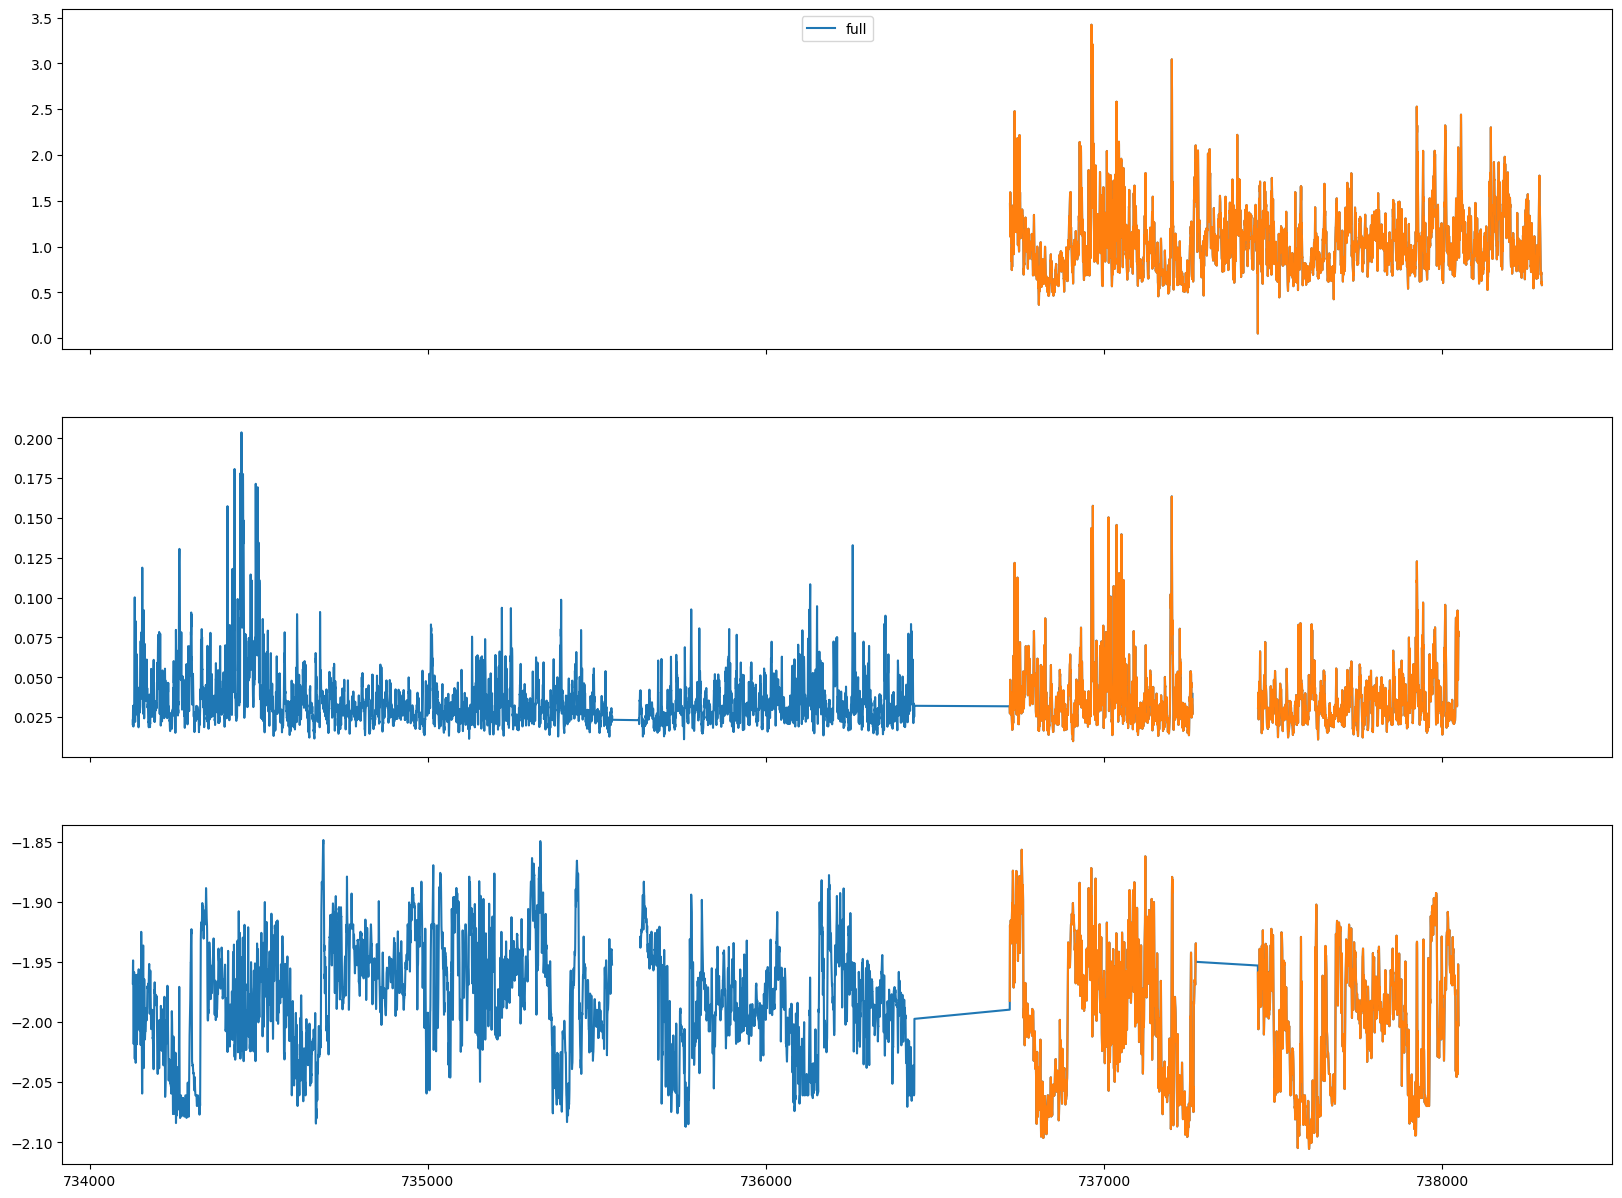

In [4]:

print('Load full ocean time series for long-term parameterization')

print('Read full M2 ocean data...')
f = h5py.File('fio_m2_old_10med.mat','r')
print(f.keys())

num_full = np.array(f.get('num')).T
spd_full = np.array(f.get('spd')).T
t_full = np.array(f.get('t')).T
spdf36_full = np.array(f.get('spdf36')).T
tf36_full = np.array(f.get('tf36')).T

print('Load raw ApRES time series')
f = h5py.File('fio_ApRES_01.mat','r')
print(f.keys())

num_pRES = np.array(f.get('dh_time'))
# dh_raw = np.array(f.get('dh_raw'))
dh_f36 = np.array(f.get('dh_f36'))
vsr_mean = np.array(f.get('vsr_mean'))

# melt rate
# mm = - (dh_raw[:,0]-vsr_mean[0][0])
mm = - (dh_f36[:,0]-vsr_mean[0][0])


print('langley dh = ')
print(str(-(0.9+0.84)))
print('')
print('ApRES dh = ')
print(str(np.nanmean(dh_f36)))
print('')
print('stake strain = ')
print(str(0.9))
print('ApRES strain = ')
print(str(vsr_mean))
print('')

#common time vector
num = num_pRES[:,0]

# interpolate ocean data to common time vector
# spd = np.interp(num,num_full[:,0],spdf36_full[:,0])
# t = np.interp(num,num_full[:,0],tf36_full[:,0])

#spd = gappy_interp(num,num_full[:,0],spdf36_full[:,0],maxgap = 4/24)
#t = gappy_interp(num,num_full[:,0],tf36_full[:,0],maxgap = 4/24)

spd = gappy_interp(num,num_full[:,0],spdf36_full[:,0],maxgap = 4/24)
t = gappy_interp(num,num_full[:,0],tf36_full[:,0],maxgap = 4/24)

print('bollean for finite tupels')
ii = np.isfinite(t*spd*mm)

print('Plot interpolated time sereies')
fig,ax=plt.subplots(3,1, sharex=True)
fig.set_figwidth(20)
fig.set_figheight(15)
#ax[0].plot(num_full,mm_opti_gampar_f36_full)
ax[0].plot(num_pRES,-(dh_f36-vsr_mean),label="full")
ax[0].plot(num,mm)
plt.sca(ax[0])
plt.legend(loc="upper center")


ax[1].plot(num_full,spdf36_full)
ax[1].plot(num,spd)
ax[2].plot(num_full,tf36_full)
ax[2].plot(num,t)
plt.show()

In [5]:
with h5py.File('m2_data_short.h5', 'w') as f:
    f.create_dataset('num', data=num)
    f.create_dataset('mm', data = mm)
    f.create_dataset('spd', data = spd)
    f.create_dataset('t', data=t)
    f.create_dataset('t_freeze', data=-2.144)
    f.create_dataset('S_w', data=34.4)
    f.create_dataset('Pb', data=340)
    f.create_dataset('T_i', data=-20)

invert 3eqn for Stanton number
Plot raw time sereies; FIXME: this plot needs to be mad properly


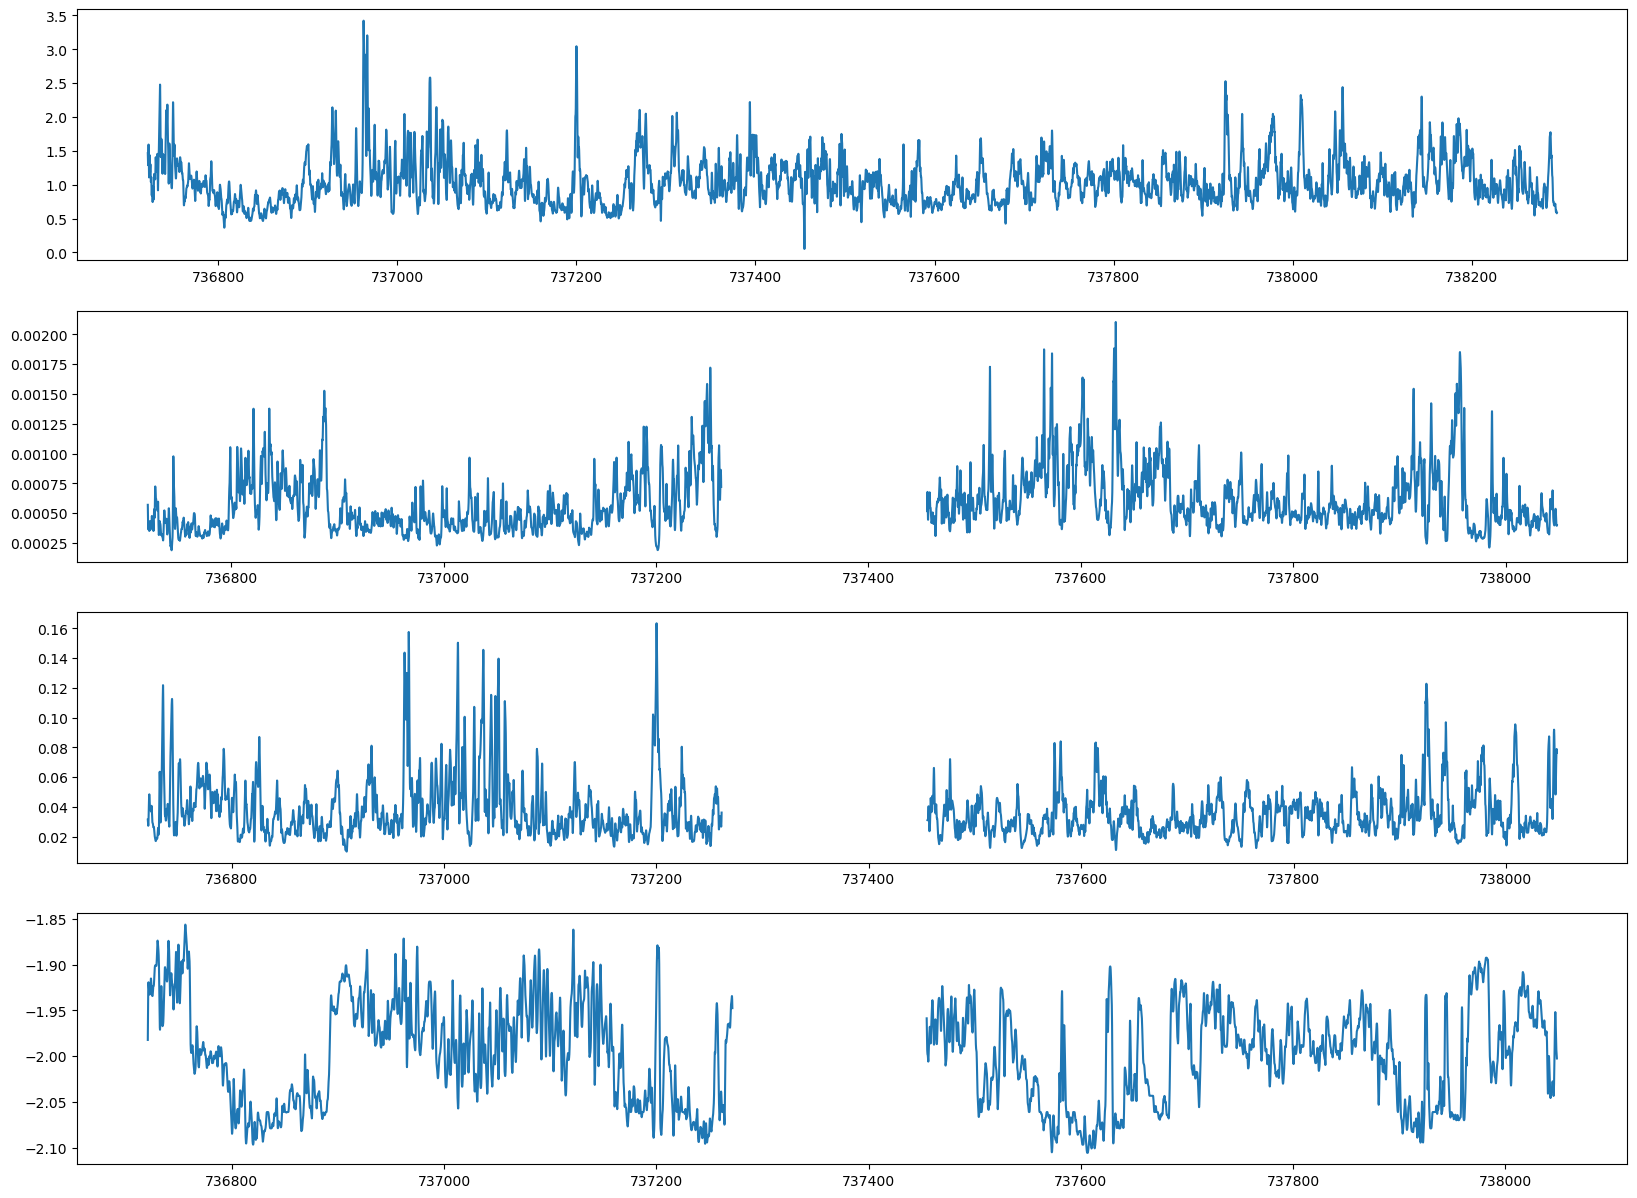

In [6]:
print('invert 3eqn for Stanton number')

ii = np.isfinite(t*spd*mm)
CdTt_obs = np.zeros(len(t))*np.nan

CdTt0=0.0011 # Thermal Stanton (first guess)

# Constants, Elin
A=rho_i*L_i
B=rho_i*c_i*T_i #
C=rho_i*c_i  # 
# D=rho_w*c_w*CdTt
E=rho_w*CdTs
F=gamma_2+gamma_3*Pb

for i in range(ii.size):
    # Use definitions of constants & and letters from last time.
    if ii[i]==True:
        # Update U,T and meltrate below for observed values
        U=spd[i]
        T=t[i]
        a=mm[i]/(365*24*3600) # Meltrate


        D = sympy.Symbol('D')
        f1=(B-A)*a-C*a*(gamma_1*S_w*E/(E+rho_i*a)+F)-D*U*(gamma_1*S_w*E/(E+rho_i*a)+F)+D*U*T
        CdTt_obs[i]=sympy.nsolve(f1,D,rho_w*c_w*CdTt0)/rho_w/c_w # Thermal Stanton number
        # print('CdTt=' + str(round(DD/rho_w/c_w,4)) +'  (Thermal Stanton number)')


print('Plot raw time sereies; FIXME: this plot needs to be mad properly')
fig,ax=plt.subplots(4,1)
fig.set_figwidth(20)
fig.set_figheight(15)
ax[0].plot(num,mm)
ax[1].plot(num,CdTt_obs)
ax[2].plot(num,spd)
ax[3].plot(num,t)

Load full ocean time series for long-term parameterization
Read Site5 ocean and ApRES data...
<KeysViewHDF5 ['T_driving', 'T_forcing', 'U_freeflow', 'cnt', 'melt_ApRES', 'optSb', 'optStantonT', 'optTb']>
Plot Site5 raw time sereies


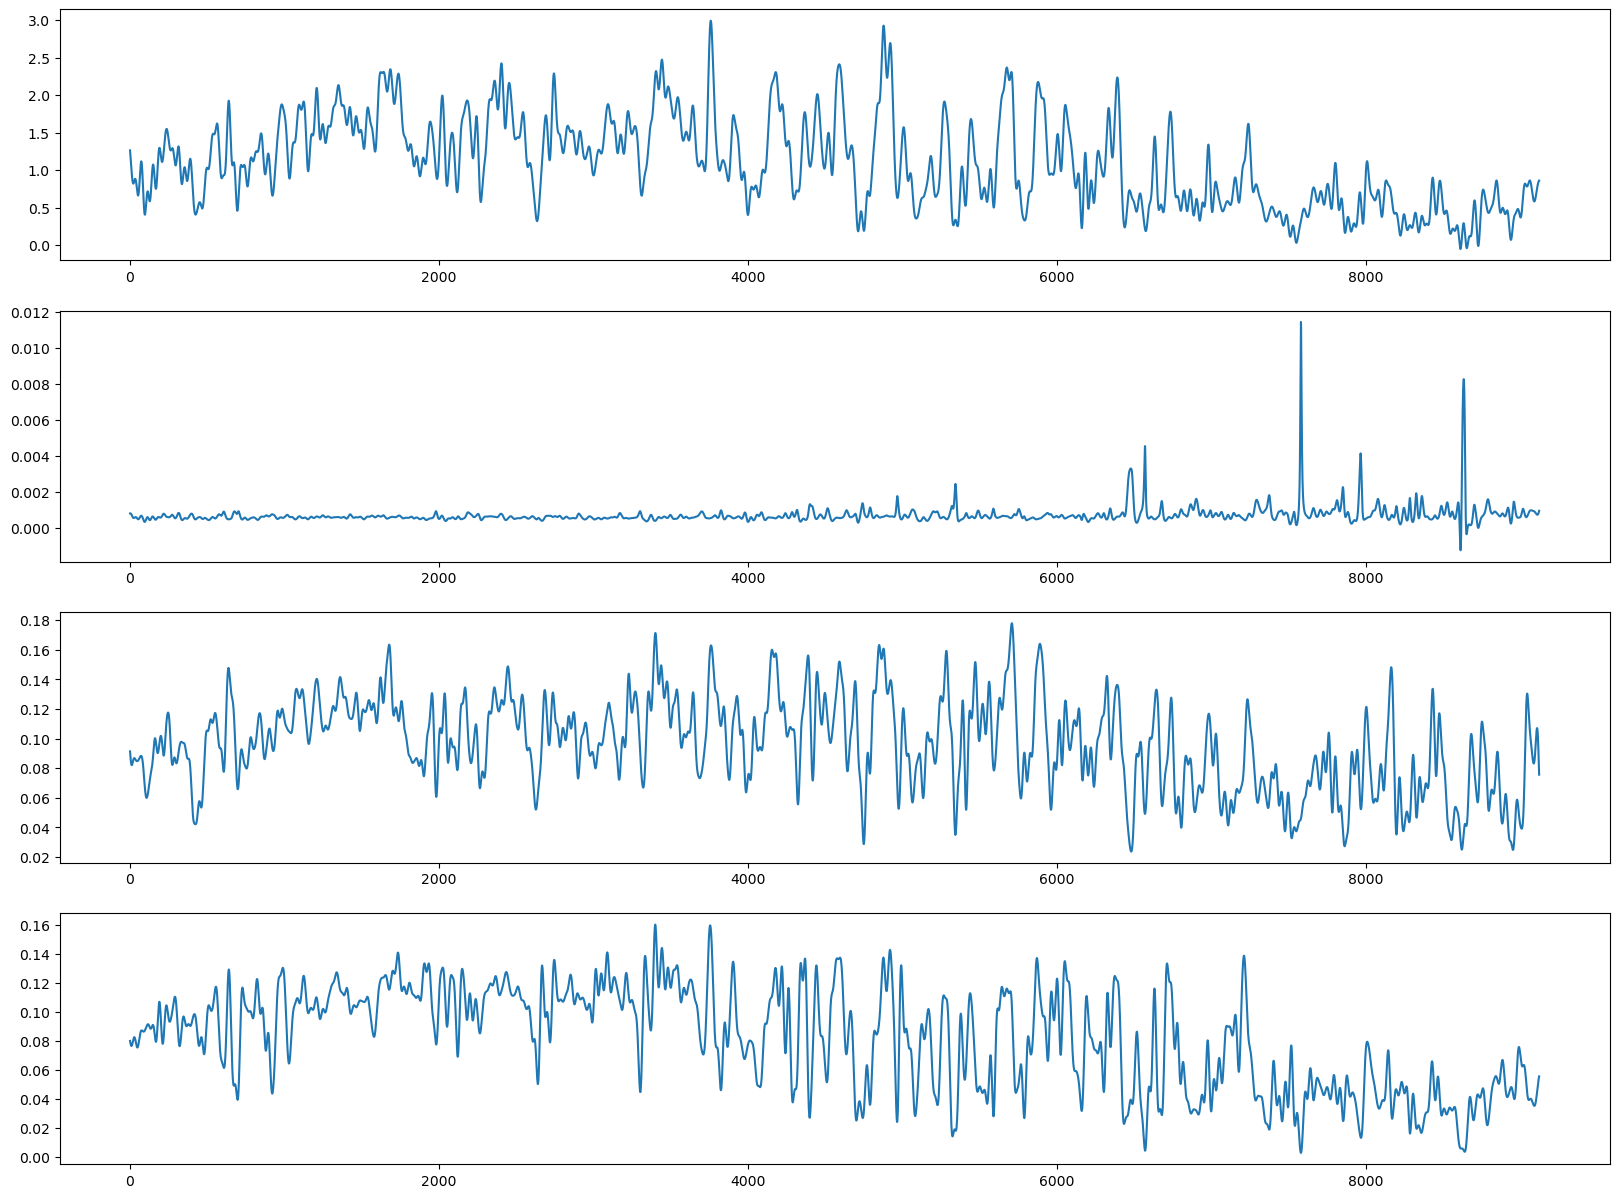

In [7]:
print('Load full ocean time series for long-term parameterization')

print('Read Site5 ocean and ApRES data...')
fs5 = h5py.File('Site5c_Stanton_v73.mat','r')
print(fs5.keys())

spd_s5 = np.array(fs5.get('U_freeflow')).T
td_s5 = np.array(fs5.get('T_driving')).T
CdTt_s5 = np.array(fs5.get('optStantonT')).T
mm_s5 = np.array(fs5.get('melt_ApRES')).T
cnt_s5 = np.array(fs5.get('cnt')).T

print('Plot Site5 raw time sereies')
fig,ax=plt.subplots(4,1)
fig.set_figwidth(20)
fig.set_figheight(15)
ax[0].plot(cnt_s5, mm_s5)
ax[1].plot(cnt_s5, CdTt_s5)
ax[2].plot(cnt_s5, spd_s5)
ax[3].plot(cnt_s5, td_s5)

# Suggested input for the paper:
After presenting the raw time series of ApRES (melt, strain) and ocean (T & U) properties, we introduce a section called something like *Functional relationship of melt rates and ocean properties*. Here we present all three methods for parameterizing melting, including the following figures in the following order:

- A time series of parameterized and observed melt + residuals (have 5 panels now, may consider some of them for supplement)

- A histogram showing the distribution of thermal driving/ free flow velocity pairs (and adopting this terminology for observed ocean speed and temperature minus local freezing pointfrom Rosevear 2022). Might consider a second panel that averages melt rates in that space.

- Histograms & quant-quant plots of paraemterized vs observed melt together with fit parameters (suggested 2x2 panel layout bleow)
  
Then to explore the varying $\Gamma_T$ parameterization, we show:

- a plot of $\Gamma_T$ parameterization in U-Td space. For better comparision with Rosevear et al. 2022, one might add a second x-axis that shows the correspnding friction velocity, using a standard drag coefficient, and ideally with the regime boundary contours from her paper overlaid.

- And a plot that shows the systematic relation between $\Gamma_T$ and the melt rates

All these figures are drafted below, although they show up in different order in the notebook for practical reasons. IMO, this is the most impactful contribution of this dataset, as it relates the observed melting and ocean properties to fundamental relationships, refining our understanding of the applicability of the existing melt rate parameterizations and confirming/ corroberating recent modelling results.

Frome there, we would go on/ branch off and investigate the time variability and procersses that controll chnages of the ocean properties, possibly on sub-tidal time scales, but that is not fully explored yet.

In [8]:

# from sklearn.metrics import r2_score

print('Define r2 score function, used for many purposes below')
print('')
def r2_score_man(y_obs, y_pred):
    """
    Calculate the coefficient of determination (R^2) between the observed data and the predicted data.

    Parameters:
    y_obs (numpy array): The observed data.
    y_pred (numpy array): The predicted data.

    Returns:
    float: The R^2 value.
    """
    # Calculate the residuals (differences between observed and predicted data)
    resid = y_pred - y_obs
    
    # Calculate the sum of squares of residuals
    SSresid = np.sum(resid ** 2)
    
    # Calculate the total sum of squares (variance of the observed data times the number of observations minus one)
    # Note: np.var with ddof=1 calculates the sample variance
    SStotal = (len(y_obs) - 1) * np.var(y_obs, ddof=1)
    
    # Calculate the R^2 value
    r2_val = 1 - SSresid / SStotal
    
    return r2_val

# Example usage
# ys = np.array([...])  # Observed data
# y1s = np.array([...]) # Predicted data
# r_squared = calculate_r_squared(ys, y1s)
# print(r_squared)

print('define quantiles for qq-metrics/-plots')
qts = np.arange(0.001, 0.999, 0.001) 
qmmq = np.quantile(mm[ii],qts)


Define r2 score function, used for many purposes below

define quantiles for qq-metrics/-plots


This is the part where we fit the 3eqn. formulation to the data. Instead of looking at the mismatch with the the data itself (r2-metric), we minimizing the mismatch of the quantiles, to get a similar data distribution. The results are not very different, but minimizing the data mismatch tends to produce larger deviations in the distributions (towards a more compressed result of the parameterized melt rates), which are highly skewed with long tails of large values which gives an asymmetric weighting of offsets at smaller values.

Below are some outputs from the process, showing the optimal fit when allowing eitehr

- for an offset in the observed melt rates (pushing all uncertainty/ error into the strain estimate), or,
- for an offset in the observed tehrmal driving (pushing all uncertainties/ error into the representataivness of the obsevred ocean properties 30 m below th ice)

Both attemtps produce a good fit, but with about an order of magnitude smaller $\Gamma_T$ than what Jenkins et al. found and with no plausible explanations for the large offstes in eitehr T or strain that we are getting. One may argue that the truth may liese somewhere in the middle, with smaller offsets in both T and melt, but still the $\Gamma_T$-vaules are a bit odd, and the below fit with variable $\Gamma_T$-vaules shows that we are probably getting the right result for the wrong reason (overfitting).

Another way of looking at this is to search for a purely empirical fit of the data, where melting is a function of U & T, or better free flow velocity $U$ and Thermal driving $\Delta_T$, which is defined as the temperature minus the local melting point at the ice-ocean interface (for consistency using the same linearization as in the 3eqn formulation). The simplest form of this is to fit a linear regression to the product of the two:

melting = a ($U$ * $\Delta_T$) + b

A physical interpretation of this would resemble the 2eqn. formulation from Jenkins et al., which assumes that variations of the interface salinity are small, and with the slope a being useful to diagnose the generalized Stanton number $\Gamma_{TS}$ from Jenkins 2012. However, in this case, b should be zero, which does not give a reasonable fit in our case. Instead, we find a comparable offset of 0.55 m/yr (to high in the observations), like for the 3 eqn. formulation. In addition, the distribution of the reatined melt rates is somewaht compressed (not capturing the highest and lowest melt rates), as can be seen in the time sereis and from the quant-quant diagramand (but higher absolute r2) than the 3 eqn. fit with constant $Gamma_T$. An imporvement can be found, when allowing for a non-linear dependency in $U$ and $\Delta_T$, optimizing for the exponents:

melting = a ($U$^0.779 * $\Delta_T$^0.649) + b

This formulation closely resembles the 3 eqn. fit (not shown/ appendix), indicating that for the Fimbulisen regime the choice of the 2 eqn. formulation, or a more sophisticated formulation does make a notable difference (as opposed to what was found in the Jenkins et al. 2010 dataset).

In [9]:
print('Optimize linear regression: melt = (T**a * u**b * slope + intercept ) for a and b')

def f_reg(pots):
    x = (t[ii] - (gamma_1*S_w + gamma_2 + gamma_3*Pb))**pots[0] * (spd[ii]**pots[1]) 
    #x = (TT - (gamma_1*S_w + gamma_2 + gamma_3*Pb))**1 * (UU**1) # linear
    reg = stats.linregress(x, mm[ii], alternative='greater')
    dum = reg.slope * x + reg.intercept
    #return 1-r2_score_man(mm[ii], dum)
    
    q_ = np.quantile(dum,qts)
    return 1-r2_score_man(qmmq, q_)

print('best initial guess:')
initial_guess = [1, 1]
print(initial_guess)
print('')

print('########## MINIMIZE regression:')
result_reg = minimize(f_reg, initial_guess, method='Powell')
print(result_reg)
print('')

print('optimized regression, non-linear')
x = (t[ii]-(gamma_1*S_w + gamma_2 + gamma_3*Pb))**result_reg.x[0] * (spd[ii]**result_reg.x[1])
reg = stats.linregress(x, mm[ii], alternative='greater')
print(reg)
print('')

print('regression, linear')
x_lin = (t[ii]-(gamma_1*S_w + gamma_2 + gamma_3*Pb)) * (spd[ii])
reg_lin = stats.linregress(x_lin, mm[ii], alternative='greater')
print(reg_lin)
print('')

# use this to control the quality of the fit:
# fig,ax=plt.subplots()
# ax.plot(x_lin,mm[ii])

print('Compute time series and max and min versions based on regression error')
dum = reg.slope * x + reg.intercept
dum_lin = reg_lin.slope * x_lin + reg_lin.intercept


# fill back into gappy time series
mm_reg = np.zeros(len(ii))*np.nan
mm_reg_lin = np.zeros(len(ii))*np.nan

mm_reg[np.squeeze(ii)] = dum
mm_reg_lin[np.squeeze(ii)] = dum_lin

print('r2 regression(optimized)')
print(str(r2_score_man(mm[ii], mm_reg[np.squeeze(ii)])))
print('r2 regression(linear)')
print(str(r2_score_man(mm[ii], mm_reg_lin[np.squeeze(ii)])))

Optimize linear regression: melt = (T**a * u**b * slope + intercept ) for a and b
best initial guess:
[1, 1]

########## MINIMIZE regression:
 message: Optimization terminated successfully.
 success: True
  status: 0
     fun: 0.01424365982569753
       x: [ 6.399e-01  7.389e-01]
     nit: 3
   direc: [[ 0.000e+00  1.000e+00]
           [-4.180e-02 -7.532e-03]]
    nfev: 115

optimized regression, non-linear
LinregressResult(slope=26.958278125986485, intercept=0.33125448668938773, rvalue=0.8864356461230647, pvalue=0.0, stderr=0.12074724304853453, intercept_stderr=0.0033520225992500026)

regression, linear
LinregressResult(slope=80.85410369188055, intercept=0.5574027359151625, rvalue=0.8865822002678369, pvalue=0.0, stderr=0.3618693548620163, intercept_stderr=0.002461132354678325)

Compute time series and max and min versions based on regression error
r2 regression(optimized)
0.7857681547176153
r2 regression(linear)
0.7860279978317587


The above scatterplot motivates the approach to vary $\Gamma_T$ as a function of the u & T parameter space. This quickly proved to improve the fit of the 3eqn. parameterization a lot. And it makes sense in terms of the different melting regimes that are described here:
https://journals.ametsoc.org/view/journals/phoc/52/10/JPO-D-21-0317.1.xml

The systematic that we find is that $\Gamma_T$ decreases as U & T (the melting) increases, whereas for cold and quiet conditions, the parameters match up well with the Jenkins et al. 2010 values. This is consistent with a transition between a fully mixed (maximum $\Gamma_T$) and the stratified (suppressed mixing) regime. We find a systematic $\Gamma_T$ distribution in T & U space, but also as a function of melt rate, suggesting that there might be a general adjustment that could be made to parameterize melting with melt-rate dependent a suppression factor.


I am really excited about the above plot, and I think this is a really important contribution to this dataset. The red values for cold and quiescent conditions are in close agreement with the Jenkins et al. 2010 values, confirming the empirical values for a well mixed regime. In contrast, for greater velocities, and in particular for higher thermal driving, the transfer coefficient drops (assuming that the drag coefficient stays unchanged) by about an order of magnitude. This is consistent with the transition into a more stratified regime, where heat fluxes are suppressed by vertical density gradients in the ISOBL (and consistent with Rosevear et al. 2022, e.g. Fig 9).

On the one hand, this shows that melting at Fimbulisen (M2) is not happening in a single regime, but that it varies. Here one could easily branch off to investigate if there is a systematic change to it, and I assume that we woudl quickly see a seasonal cycle, where during the arrival of ASW with warmer temperatures in July (Lauber et al. 2024, TC), the stratified regime dominates, while during times when ISW and colder temperatures are observed in Aril to June at the mooring, the well-mixed regime dominates.

Another important an more general implication of these results is that (a) the 3eqn. formulation seems to work really well in the quiescent and cold mixed regime (as others have pointed out), while (at least for Fimbulisen/ M2) an empirical relationship may be found (as illustrated in the above figure), on how the transition into a faster-flowing and warmer regime will suppress the transfer coefficient. Who knows, maybe the relationship for $\gamma_T$ (now talking about the transfer coefficient itself, not the Stanton number) as a function of thermal driving and free flow velocity that we see here, is a general one. In that case, these observations could immediately hep to improve formulations of basal melting in ocean models (which now use a constant gamma to tune for whatever case). I think this is really really exciting, and I suggest that we prioritize getting this point across in the paper.

In fact, with some more work, one could try to scrutinize existing parameterizations that account for the suppression of the transfer coefficient in the presence of stratification (mainly applied in sea ice) by estimating the stratification from the interface salinity, which can be diagnosed from the 3eqn. formulation. In this way, the ISOBL is simpler than the sea ice case, because freshwater fluxes are more constrained (along the Gade lines). Still, there will be slope, roughness, and pressure, which, together with an unknown vertical profile, leaves enough ambiguity, but at least we see some consistent, systematic change here.

Another way of looking at it is that--if all stratification is caused by interface fluxes, i.e. meltwater input--the transfer coefficient may be a function of the melt rate itself. A quick-an-dirty plot-and-see exercise indicates that this might indeed be the case here, where the square root of $\Gamma_T$ increases (roughly linear) with the inverse of the melt rates. Again, via the 3eqn. formulation and an expression for the BL-stratification, this relationship may possibly be linked/ derived, and again with the caveats of other environmental properties making things more complicated for a general approach.

Regardless fo how far we push this, I think the above and below figures should be presented and discussed in the paper, as the most general result of this study.


Parameterize suppression factor as asymptotic function:  
$s = s_0 +\frac{ax^n}{x^n+b} = 0.4 + \frac{5.18 {\Delta T}^{1.18}}{{\Delta T}^{1.18} + 66 \times 10^{-4}u^{-1}}$

This is a fit that prescribes s_0 to obtain a balanced fit, optimizing r2 values for the direct fit and the quant-quant distribution. Optimizing the direct fit only gives a lower s_0 and slightly less optimal distribution; optimizing for the distribution reduces the direct fit (too much).

--------------------------
Moin nochmal, was deine Regressionsgleichung fuer s angeht, ist der einzige relevante Term bei McPhee zum Vergleichen etastar^2 = 1/(1+const*<w'b'>/ustar^2), auch wenn der eigentlich nur ausserhalb des LOW gilt.  
- Wenn man <w'b'> ~ ustar annimmt, dann stimmen deine Regressionsgleichung und die fuer etastar^2 in der Asymptote fuer ustar->0 nicht ueberein (bei dir: 1/(s0+U/b), bei McPhee: U/(U+const)). *T: This suggest not to have DeltaT in the nominator*  
- Problematischer ist aber vielleicht die Tatsache, dass selbst fuer DeltaT->0 bei dir noch U in der Asymptote steckt: 1/(s+aU/b), waehrend Monin-Obukhov einfach gegen 1 geht (kein Schmelzen, keine Stratifizierung). Auch unendlich starkes Schmelzen (DeltaT-> inf) fuehrt bei dir zu konstanter Reduzierung 1/(s0+a) anstelle von Reduzierung bis 0.  
Fuer die letzten Aussagen habe ich angenommen, dass in deiner Regressionsgleichung x=DeltaT ist, was du anscheinend gefittet hast, wenn ich den Rest des Dokuments recht verstehe. *T: This suggests scaling u with DeltaT*; **U-dependence for DeltaT->0 might be ok, since this effect is tapered off by multiplication with thermal driving in the parameterization; less sure about infinte melting, ther migth be some sort of saturation effect**

Fuers Fitten wuerde ich, zumindest aufgrund der Asymptoten und McPhee etc., empfehlen: 1/(1+const*DeltaT/U). Aber letztlich ist das ja alles nur Empirie, also sollte man nehmen, was am besten passt.

Achim


optimize suppressed melt parameterization
initial guess: (5.0, 0.009, 0.5, 0.4)
find optimal suppression factor parameters:
[4.19277048e+00 2.98965547e-03 1.17166786e+00 4.00000000e-01]

r2-score suppressed melt and quantiles
0.7863888005444344
0.9810966600090686


C:\Users\hattermann\AppData\Local\miniforge3\envs\fio_fieldwork\Lib\site-packages\scipy\optimize\_minpack_py.py:1010: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',


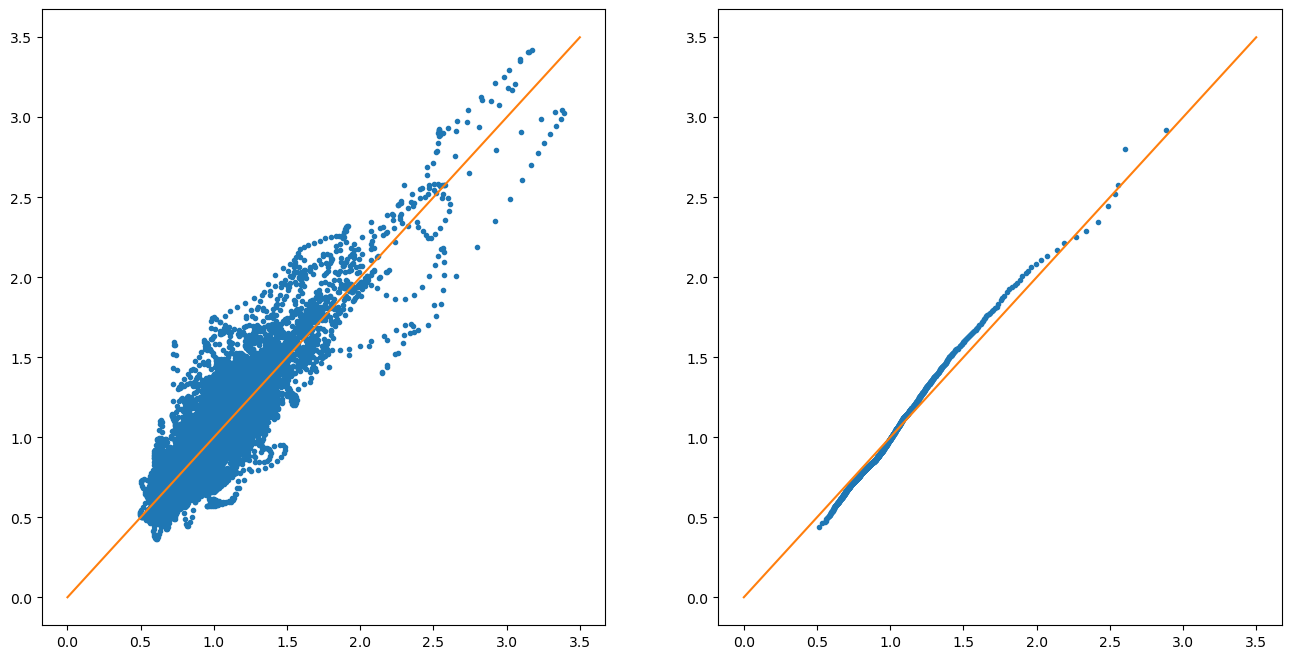

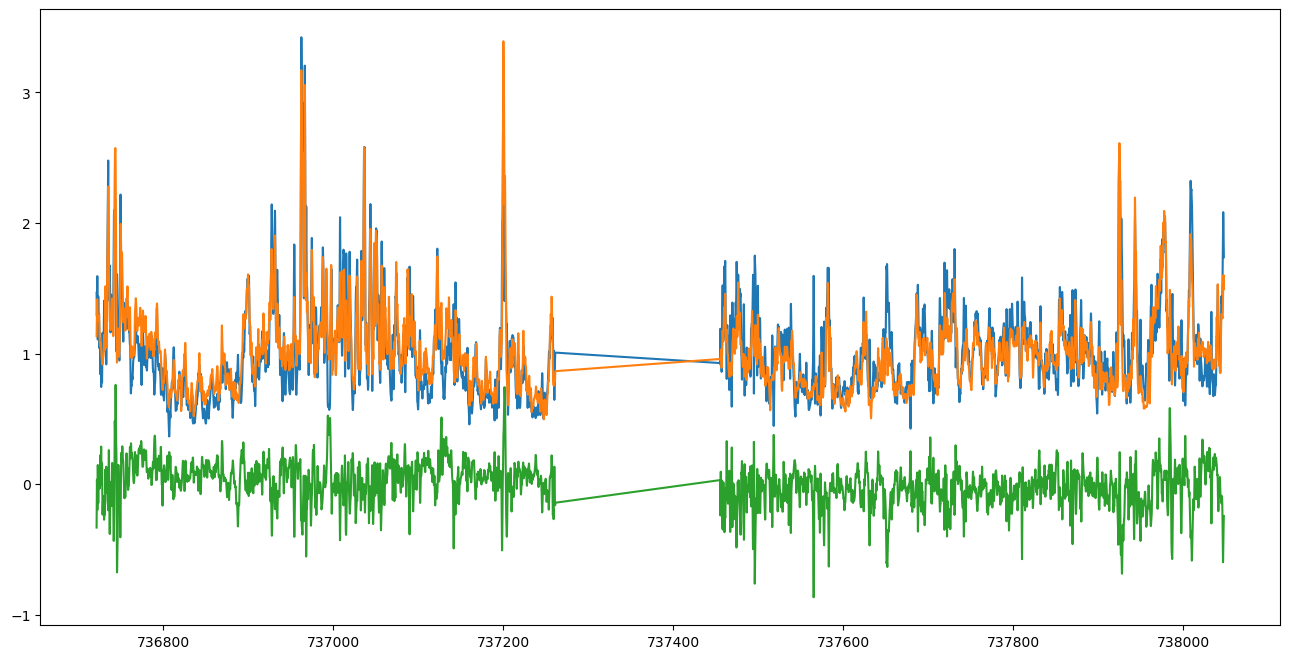

In [10]:
print('optimize suppressed melt parameterization')
s0_ = 0.4
def dmelt_para(M,a,b,n,d0):
    aa=[] # output
    t_in = M[0] # tempeature
    u_in = M[1] # velocity
    td = t_in-(gamma_1*S_w + gamma_2 + gamma_3*Pb) # thermal driving

    #print(args)
    # a = p0[0]# args[0] # tuning coeff
    # b = p0[1] #args[1] # tuning coeff
    # n = p0[2] #args[2] # tuning coeff
    # a = 5
    #b = p0
    # n = 0.5
    # damp = 0.5+(5 * td ** 0.5  / (td ** 0.5 + b/u_in)) # dampening factor
    # damp = d0+(a * td ** n  / (td ** n + b/u_in)) # full freedom
    # damp = d0+(a * td ** 1  / (td ** 1 + b/u_in)) # constant exponent
    
    # Achim form, not satisfying:
    # damp = d0 + (1 / ((a*(td) **n)/u_in + b)) # fixed offset  

    # fix behvior for u->0
    damp = s0_ +(a * (td*u_in) ** n  / ((td*u_in) ** n + b)) # fixed offset
    
    # allow infinte growth (compresses all asymptotic approach in lower values, and then fits lager rates
    # damp = d0 + (1  / ((td*u_in) ** n + b)) # fixed offset
   
    # all free parameters to optimize direct fit (less slightly worse distribution)
    # damp = d0+(a * td ** n  / (td ** n + b/u_in)) # fixed offset

    # balanced best fit (direct + distribution)
    # damp = s0_ +(a * td ** n  / (td ** n + b/u_in)) # fixed offset   

    CdTt0 = 0.0011 # Jenkins Stanton number
    CdTt= CdTt0/damp # dampened thermal Stanton number
    #CdTs=CdTt/30 # assume fixed ratio of thermal and saline Stanton numbers
    CdTs=CdTt/35 # assume fixed ratio of thermal and saline Stanton numbers

    # Constants, Elin
    A=rho_i*L_i
    B=rho_i*c_i*T_i #
    C=rho_i*c_i  # 
    D=rho_w*c_w*CdTt
    E=rho_w*CdTs
    F=gamma_2+gamma_3*Pb

    # time sereis input
    T = t_in
    U = u_in

    # Elin's analytsical expression
    aa=rho_i*(B-A-C*F)
    bb=E*(B-A)-C*gamma_1*S_w*E-C*F*E-D*U*F*rho_i+D*U*T*rho_i
    cc=D*U*T*E-D*U*F*E-D*U*gamma_1*S_w*E
    aa=N*(-bb-np.sqrt(bb**2-4*aa*cc))/(2*aa) # meltrate [m/yr]
    return aa

def dmelt_para_dist(M,a,b,n,d0): # fit for optimal distribution    
    return r2_score_man(qmmq,np.quantile(dmelt_para(M,a,b,n,d0),qts))

p0 = 5., .009, .5, s0_ # a, b, n, d0
print('initial guess: ' + str(p0))

print('find optimal suppression factor parameters:')
i_ = np.isfinite(t*spd*mm)
popt_melt, pcov = curve_fit(dmelt_para, [t[i_], spd[i_]], mm[i_], p0, maxfev = 12000)
# popt_melt, pcov = curve_fit(dmelt_para_dist, [t[i_], spd[i_]], mm[i_], p0, maxfev = 12000)
print(str(popt_melt))
print('')

print('r2-score suppressed melt and quantiles')
dum = dmelt_para([t[i_], spd[i_]],popt_melt[0],popt_melt[1],popt_melt[2],popt_melt[3])
qmmq_damp = np.quantile(dum,qts)
print(str(r2_score_man(mm[i_], dum)))
print(str(r2_score_man(qmmq, qmmq_damp)))

fig, ax = plt.subplots(1,2, figsize=np.array([16,8]))
xy = [0,3.5]
ax[0].plot(dum,mm[i_],'.')
ax[0].plot(xy,xy)

ax[1].plot(qmmq_damp,qmmq,'.')
ax[1].plot(xy,xy)

plt.show

fig, ax = plt.subplots(1, figsize=np.array([16,8]))
ax.plot(num[i_],mm[i_])
ax.plot(num[i_],dum)
ax.plot(num[i_],dum-mm[i_])

# From latest best fit:
#
# optimize suppressed melt parameterization
# initial guess: (5.0, 0.009, 0.5, 0.5)
# find optimal suppression factor parameters:
# [4.57034295 0.00639147 1.1677973  0.5       ]
#
# r2-score suppressed melt and quantiles
# 0.7865434562484315
# 0.9852202842870611

In [11]:
# check out taylor diagram
#  https://doi.org/10.1029/2000JD900719
# https://pypi.org/project/SkillMetrics/
# https://github.com/PeterRochford/SkillMetrics/blob/master/Examples/taylor5.py

# # Calculate statistics for Taylor diagram
# # The first array element (e.g. taylor_stats1[0]) corresponds to the 
# # reference series while the second and subsequent elements
# # (e.g. taylor_stats1[1:]) are those for the predicted series.
# taylor_stats1 = sm.taylor_statistics(data['pred1'],data['ref'],'data')
# taylor_stats2 = sm.taylor_statistics(data['pred2'],data['ref'],'data')
# taylor_stats3 = sm.taylor_statistics(data['pred3'],data['ref'],'data')
#     
# # Store statistics in arrays
# sdev = np.array([taylor_stats1['sdev'][0], taylor_stats1['sdev'][1], 
#                  taylor_stats2['sdev'][1], taylor_stats3['sdev'][1]])
# crmsd = np.array([taylor_stats1['crmsd'][0], taylor_stats1['crmsd'][1], 
#                   taylor_stats2['crmsd'][1], taylor_stats3['crmsd'][1]])
# ccoef = np.array([taylor_stats1['ccoef'][0], taylor_stats1['ccoef'][1], 
#                   taylor_stats2['ccoef'][1], taylor_stats3['ccoef'][1]])
# 
#     # Specify labels for points in a cell array (M1 for model prediction 1,
#     # etc.). Note that a label needs to be specified for the reference even
#     # though it is not used.
# label = ['Non-Dimensional Observation', 'M1', 'M2', 'M3']
# 
# sm.taylor_diagram(sdev,crmsd,ccoef, markerLabel = label,
#                       markerLabelColor = 'r', markerLegend = 'on', 
#                       tickRMS = range(0,60,10), tickRMSangle = 110.0,
#                       colRMS = 'm', styleRMS = ':', widthRMS = 2.0, 
#                       titleRMS = 'off', tickSTD = range(0,80,20), 
#                       axismax = 60.0, colSTD = 'b', styleSTD = '-.', 
#                       widthSTD = 1.0, titleSTD = 'off', 
#                       colCOR = 'k', styleCOR = '--', widthCOR = 1.0, 
#                       titleCOR = 'off')

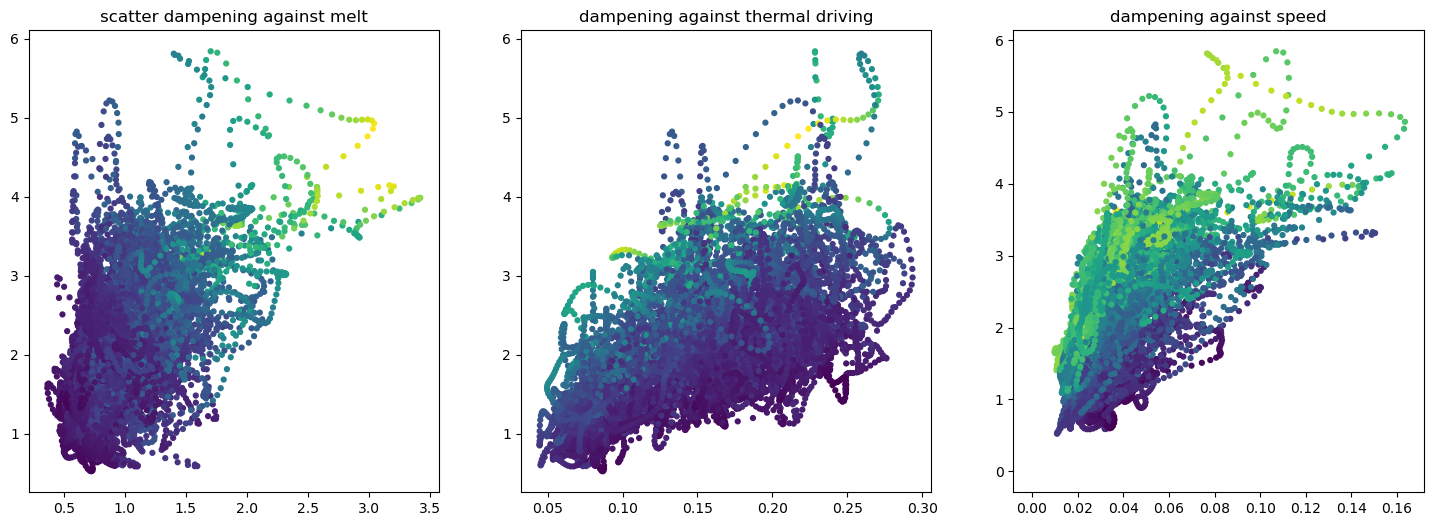

In [12]:

expo = 1

fig, ax = plt.subplots(1,3, figsize=np.array([18, 6]))
plt.sca(ax[0])
plt.scatter(mm[ii],CdTt0/CdTt_obs[ii],s=12,c=spd[ii])
ax[0].set_title("scatter dampening against melt")

plt.sca(ax[1])
plt.scatter((t[ii]+2.15)**expo,(CdTt0/CdTt_obs[ii]),s=12,c=spd[ii])
plt.title("dampening against thermal driving")


plt.sca(ax[2])
plt.scatter(spd[ii],(CdTt0/CdTt_obs[ii]),s=12,c=t[ii]+2.15)
plt.title("dampening against speed")
ax[2].plot(0,0)


In [13]:
print('optimal fit for suppression factor expression')
def ss(M,a,b,n,s0):
    t_in = M[0] # tempeature
    u_in = M[1] # velocity
    td = t_in-(gamma_1*S_w + gamma_2 + gamma_3*Pb) # thermal driving

    # fix to suppresion fucntion parameters to values obatined from from melt rate optimization
    # a = 4.94360332
    # b = 0.00576993
    # n = 1.19938968
    
    # s0 = 0.4

    #damp = 0.5+(a * td ** n  / (td ** n + b/u_in)) # fixed offset

    # damp = s0 + (a * td ** n  / (td ** n + b/u_in)) # dampening factor
    
    # Achim new form
    damp = s0_ +(a * (td*u_in) ** n  / ((td*u_in) ** n + b)) 
    return damp

def ssq(M,a,b,n,s0):
    dampq = np.quantile(ss(M,a,b,n,s0),qts)
    return dampq


p0 = 5., .009, .5, .5 # a, b, n, s0
p0 = popt_melt # [4.94360332, 0.00576993, 1.19938968, 0.5       ] # from optimizing melt
i_ = np.isfinite(t*spd*mm)

popt_damp, pcov = curve_fit(ss, [t[i_], spd[i_]], CdTt0/CdTt_obs[i_], p0, maxfev = 12000)

#dampq_obs = np.quantile(CdTt0/dd[i_[:,0]],qts)
#popt, pcov = curve_fit(ssq, [t[i_], spd[i_]], dampq_obs, p0, maxfev = 12000)
print('optimal suppression parameters: a, b, n, ss0')
#popt = [4.94360332, 0.00576993, 1.19938968, 0.5       ]
print(str(popt_damp))
print('')

print('compute suppression factor and parameterized melt rates')
ss_opt = ss([t, spd],popt_melt[0],popt_melt[1],popt_melt[2],popt_melt[3])
mm_ss = dmelt_para([t, spd],popt_melt[0],popt_melt[1],popt_melt[2],popt_melt[3])
print('')

# quantiles
qmmq = np.quantile(mm[i_],qts)
qmmq_damp = np.quantile(mm_ss[i_],qts)

print('r2-score parameterized melt and quantiles')
print(str(r2_score_man(mm[i_], mm_ss[i_])))
print(str(r2_score_man(qmmq, qmmq_damp)))
print('')


optimal fit for suppression factor expression
optimal suppression parameters: a, b, n, ss0
[4.63993751e+00 4.01210178e-03 1.13348694e+00 4.00000000e-01]

compute suppression factor and parameterized melt rates

r2-score parameterized melt and quantiles
0.7863888005444344
0.9810966600090686



Make some refrence plots


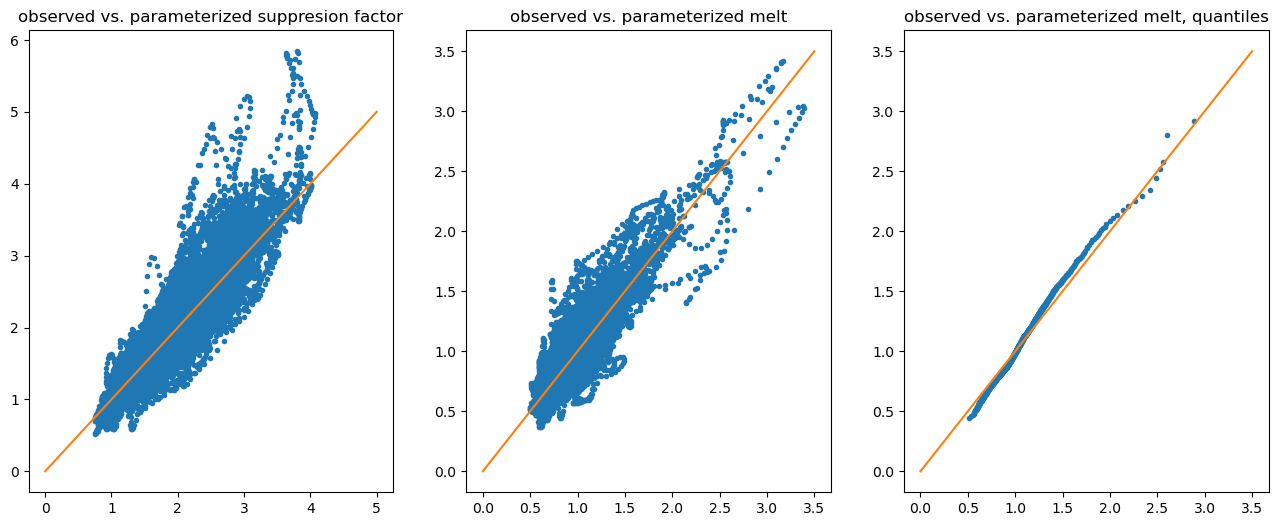

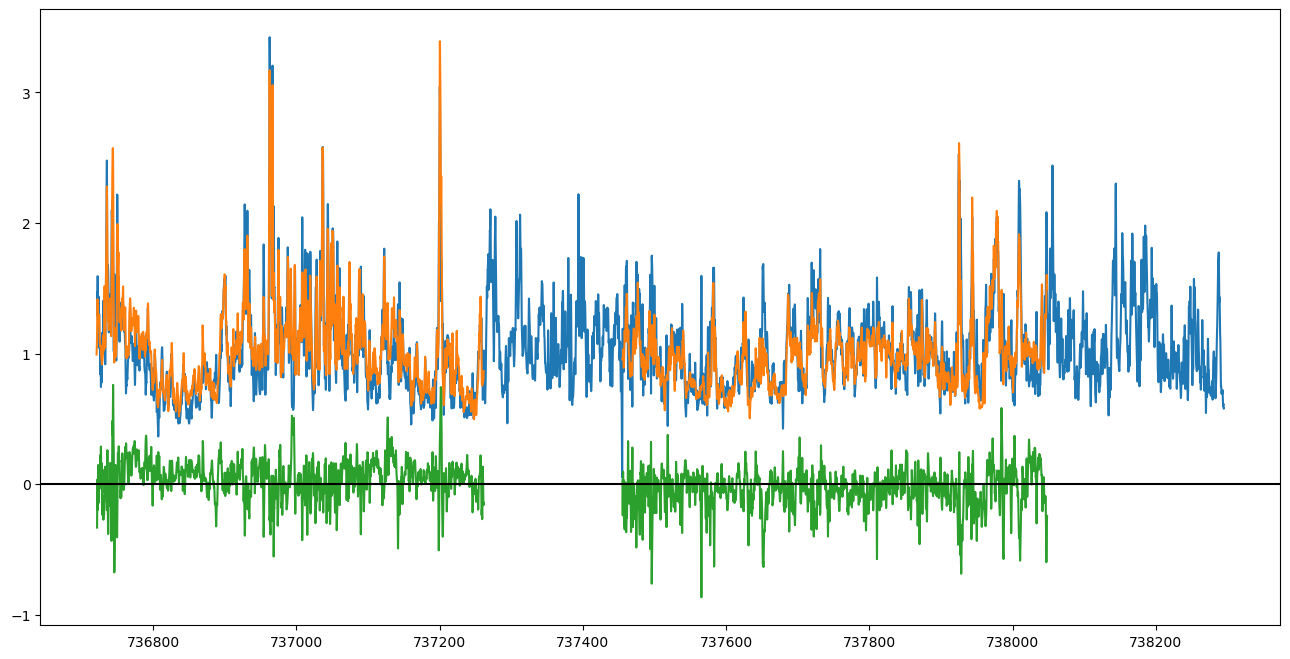

In [14]:
print('Make some refrence plots')

fig, ax = plt.subplots(1,3, figsize=np.array([16,6]))
ax[0].plot(ss_opt,CdTt0/CdTt_obs,'.')
ax[0].plot([0,5],[0,5])
ax[0].set_title("observed vs. parameterized suppresion factor")

xy = [0,3.5]
ax[1].plot(mm_ss,mm,'.')
ax[1].plot(xy,xy)
ax[1].set_title("observed vs. parameterized melt")

ax[2].plot(qmmq_damp,qmmq,'.')
ax[2].plot(xy,xy)
ax[2].set_title("observed vs. parameterized melt, quantiles")
plt.show

fig, ax = plt.subplots(1, figsize=np.array([16,8]))
ax.plot(num,mm)
ax.plot(num,mm_ss)
ax.plot(num,mm_ss-mm)
plt.sca(ax)
plt.axhline(y = 0, color = 'k', linestyle = '-')

In [15]:
print('phase-space statistics of melt, suppression, etc')
td = t-(gamma_1*S_w + gamma_2 + gamma_3*Pb)
bool = ~np.isnan(td) & ~np.isnan(spd) & ~np.isnan(mm) # fint finite value tupels

#tdbins = np.arange(0.02, 0.32, 0.01)
tdbins = np.arange(0.02, 0.4, 0.01)
ubins = np.arange(0, 0.18, 0.005)

tdi = tdbins
ui = ubins # np.concatenate([np.arange(0, 0.06, 0.01), np.arange(0.06, 0.18, 0.04)])

tdim = 0.5*(tdi[0:-1]+tdi[1:])
uim = 0.5*(ui[0:-1]+ui[1:])

tdg, ug = np.meshgrid(tdim, uim)

hist = stats.binned_statistic_2d( spd[bool], td[bool], None, bins=[ubins, tdbins], statistic='count')  # Returns a object
hist.statistic[hist.statistic == 0] = np.nan  # Sets all values of 0 to nan as log10(0) = -inf

mm_mean = stats.binned_statistic_2d( spd[bool], td[bool], mm[bool], bins=[ubins, tdbins], statistic='mean')  # Returns a object
# binning parameterized melt, not in use her,e but for exploring fucntional relationship
mm_ss_mean = stats.binned_statistic_2d( spd[bool], td[bool], mm_ss[bool], bins=[ubins, tdbins], statistic='mean')  # Returns a object
ss_opt_mean = stats.binned_statistic_2d( spd[bool], td[bool], ss_opt[bool], bins=[ubins, tdbins], statistic='mean')  # Returns a object
CdTt_obs_mean = stats.binned_statistic_2d( spd[bool], td[bool], CdTt_obs[bool], bins=[ubins, tdbins], statistic='mean')  # Returns a object

ss_grid = ss([tdg+(gamma_1*S_w + gamma_2 + gamma_3*Pb), ug],popt_melt[0],popt_melt[1],popt_melt[2],popt_melt[3])
mm_grid = dmelt_para([tdg+(gamma_1*S_w + gamma_2 + gamma_3*Pb), ug],popt_melt[0],popt_melt[1],popt_melt[2],popt_melt[3])

phase-space statistics of melt, suppression, etc


Plot and save phase space plots, melt & suppression as function of free flow velocity and thermal driving:
FIXME: logarithmic axes



C:\Users\hattermann\AppData\Local\Temp\ipykernel_14056\3440108823.py:5: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap('Spectral_r', 64)
C:\Users\hattermann\AppData\Local\Temp\ipykernel_14056\3440108823.py:42: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.
  plt.scatter([4.3, 3.7, 3.9, 4.0],[.23, .17, .16, .19],
C:\Users\hattermann\AppData\Local\Temp\ipykernel_14056\3440108823.py:63: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have preceden

<function matplotlib.pyplot.show(close=None, block=None)>

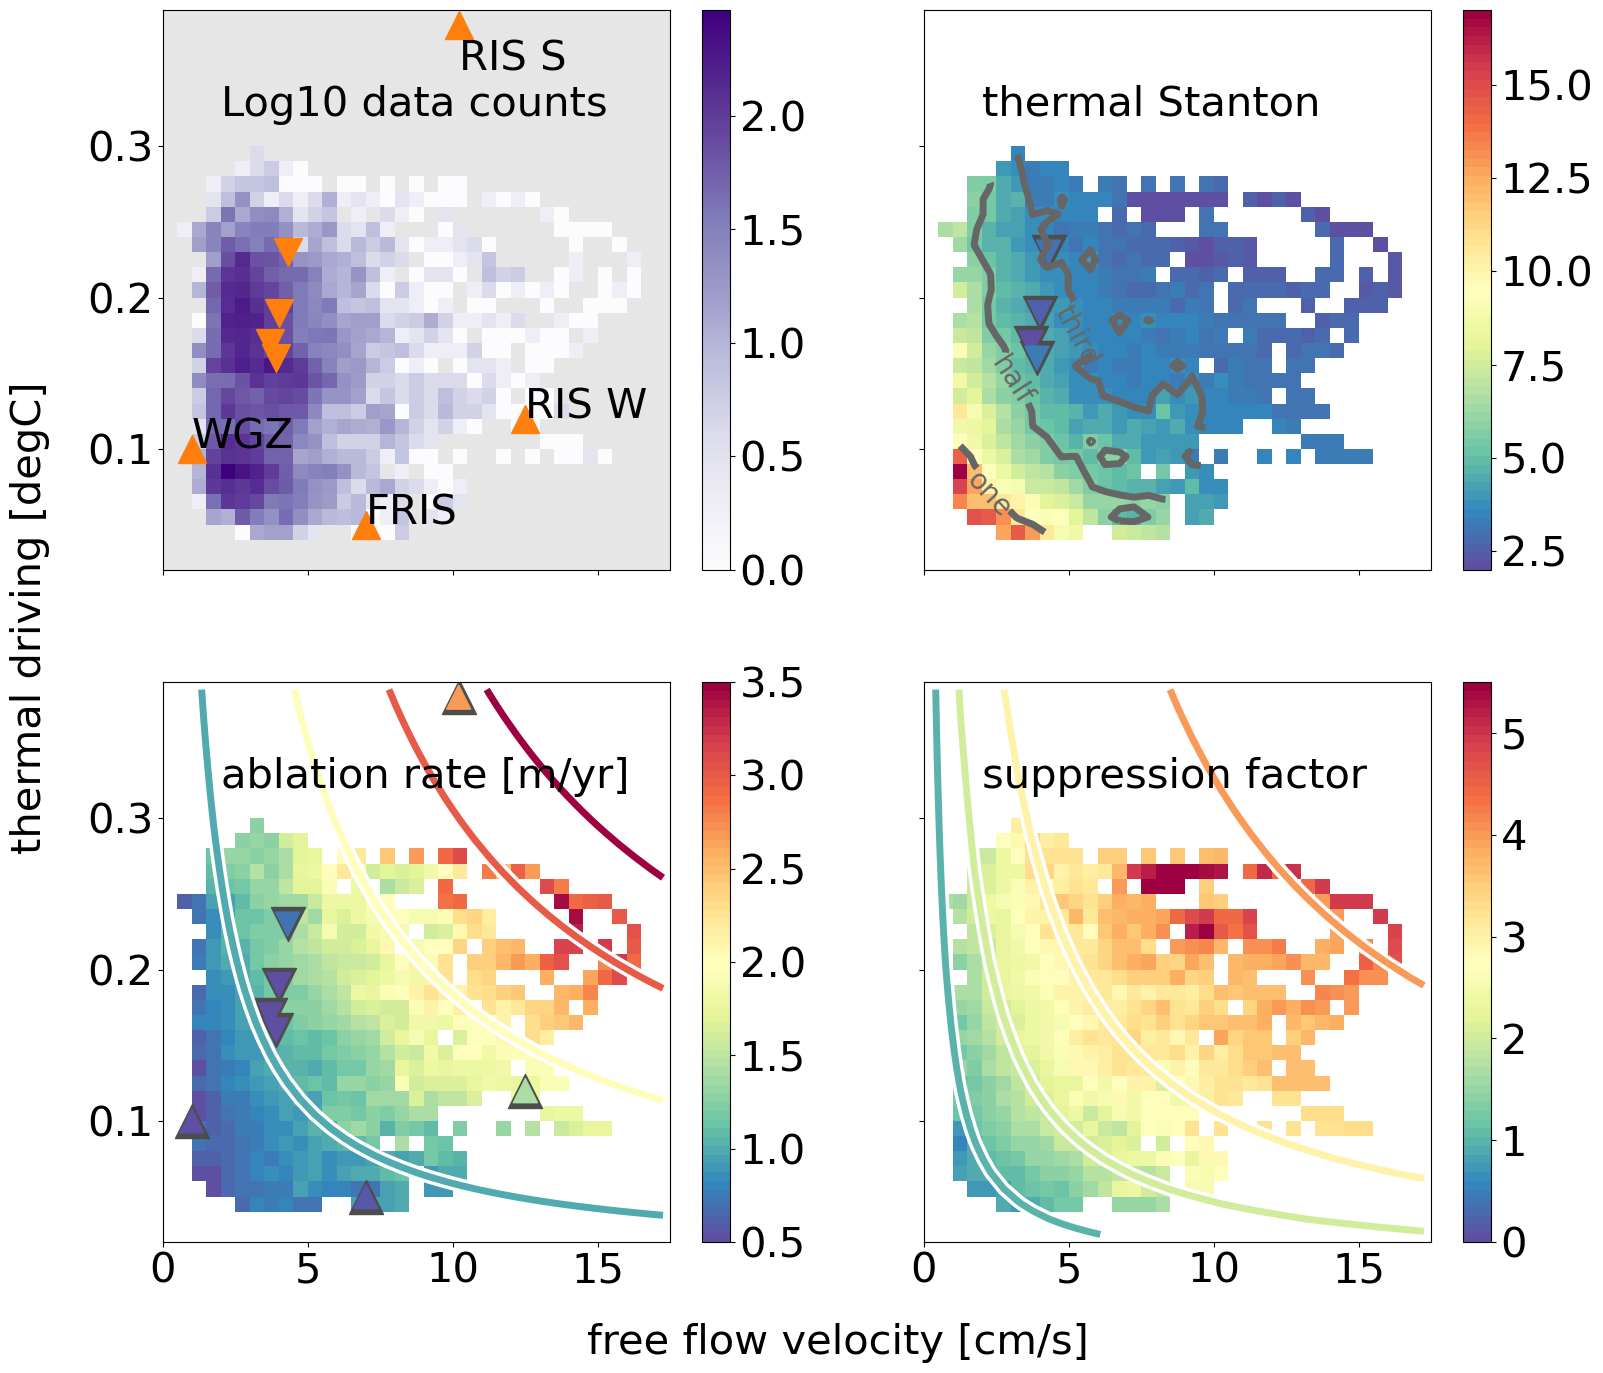

In [16]:
print('Plot and save phase space plots, melt & suppression as function of free flow velocity and thermal driving:')
print('FIXME: logarithmic axes')
print('')

cmap = plt.cm.get_cmap('Spectral_r', 64)
cm = ['RdBu_r', 'Purples', 'cividis']

plt.rcParams.update({'font.size': 30})
fig, ax = plt.subplots(2,2, sharex=True, sharey=True, figsize=np.array([18, 16]))

plt.sca(ax[0,0])
ax[0,0].set_facecolor((.9, .9, .9))
image = plt.pcolormesh(ui*100, tdi, np.log10(hist.statistic.T), cmap=cm[1], shading='flat')
fig.colorbar(image, ax=ax[0,0])
# Rosevear
# https://os.copernicus.org/articles/18/1109/2022/
ax[0,0].plot([4.3, 3.7, 3.9, 4.0],[.23, .17, .16, .19], "v",
            markersize=20,c="C1")
# Others: RIS S, RIS W, WGZ, FRIS; Stewart 2018, Begemann 2018, Jenkins 2010b
ax[0,0].plot([10.2, 12.5, 1, 7],[.38, .12, .1, 0.05], "^",
            markersize=20,c="C1")
ax[0,0].text(10.2,.38-0.03, "RIS S")
ax[0,0].text(12.5,.12, "RIS W")
ax[0,0].text(1,.1, "WGZ")
ax[0,0].text(7,.05, "FRIS")
ax[0,0].text(2,.32, "Log10 data counts")


plt.sca(ax[0,1])
cnts = [CdTt0/3*10**4, CdTt0/2*10**4, CdTt0*10**4, 2*CdTt0*10**4]
image = plt.pcolormesh(ui*100, tdi, CdTt_obs_mean.statistic.T*10**4, 
                       cmap=cmap, shading='flat', vmin = 2, vmax = 17) 
cnt = plt.contour(uim*100, tdim, CdTt_obs_mean.statistic.T*10**4,cnts,
                  colors=[.4, .4, .4, 1], linewidths=5.0, vmin = 2, vmax = 17)
fmt = {}
strs = ['third', 'half', 'one']
for l, s in zip(cnt.levels, strs):
    fmt[l] = s
# Label every other level using strings
ax[0,1].clabel(cnt, cnt.levels[:], inline=True, fmt=fmt, fontsize=20)

plt.scatter([4.3, 3.7, 3.9, 4.0],[.23, .17, .16, .19], 
   s=600, marker="v",c=[.3, .3, .3],zorder=1)

plt.scatter([4.3, 3.7, 3.9, 4.0],[.23, .17, .16, .19], 
            s=300,c=[3.1, 1.7, 3.3, 2.7],
            vmin = 2, vmax = 17,
            cmap=cmap, marker="v",zorder=1)
ax[0,1].text(2,.32, "thermal Stanton")

# plt.clabel(cnt, inline=True, fontsize=10)
fig.colorbar(image, ax=ax[0,1])

plt.sca(ax[1,0])
#cnts = [0.5, 1, 1.5, 2, 2.5, 3, 3.5]
cnts = [1, 2,  3, 4]
image = plt.pcolormesh(ui*100, tdi, mm_mean.statistic.T, cmap=cmap, shading='flat', vmin = 0.5, vmax = 3.5) 
# plt.contour(uim*100, tdim, mm_ss_mean.statistic.T, colors='white', linewidths=10.0)
# plt.contour(uim*100, tdim, mm_ss_mean.statistic.T, cmap=cmap, vmin = 0.5, vmax = 3.5, linewidths=5.0)
plt.contour(uim*100, tdim, mm_grid.T, cnts, colors="white", linewidths=10.0)
plt.contour(uim*100, tdim, mm_grid.T, cnts, cmap=cmap, vmin = 0.5, vmax = 3.5, linewidths=5.0)

plt.scatter([4.3, 3.7, 3.9, 4.0],[.23, .17, .16, .19], 
            s=600, marker="v",c=[.3, .3, .3])
plt.scatter([4.3, 3.7, 3.9, 4.0],[.23, .17, .16, .19], 
            s=300,c=[.71, .26, .48, .46], 
            cmap=cmap, marker="v", vmin = 0.5, vmax = 3.5,zorder=1)

plt.scatter([10.2, 12.5, 1, 7],[.38, .12, .1, 0.05], 
            s=600, marker="^",c=[.3, .3, .3])
plt.scatter([10.2, 12.5, 1, 7],[.38, .12, .1, 0.05], 
            s=300,c=[2.7, 1.4, 0.05, 0.55], 
            cmap=cmap, marker="^", vmin = 0.5, vmax = 3.5,zorder=1)
ax[1,0].text(2,.32, "ablation rate [m/yr]")

fig.colorbar(image, ax=ax[1,0])

plt.sca(ax[1,1])
cnts = [1, 2, 3, 4, 5]
image = plt.pcolormesh(ui*100, tdi, CdTt0/CdTt_obs_mean.statistic.T, cmap=cmap, shading='flat', vmin = 0, vmax = 5.5) 
plt.contour(uim*100, tdim, ss_grid.T, cnts, colors='white', linewidths=10.0)
plt.contour(uim*100, tdim, ss_grid.T, cnts, cmap=cmap, vmin = 0, vmax = 5.5, linewidths=5.0)
fig.colorbar(image, ax=ax[1,1])

fig.text(0.5, 0.04, 'free flow velocity [cm/s]', ha='center')
fig.text(0.04, 0.5, 'thermal driving [degC]', va='center', rotation='vertical')
#ax.set_xlabel('free flow velocity [cm/s]')
#ax.set_ylabel('thermal driving [degC]')
#plt.grid()
ax[1,1].text(2,.32, "suppression factor")

#fig.colorbar(image, ax=ax, label='$\Gamma_T^0 / \Gamma_T$ '); 

plt.savefig("../plot/gamma_dampening_distribution.png",bbox_inches='tight')
plt.show


Compare Site 5 data range


<function matplotlib.pyplot.show(close=None, block=None)>

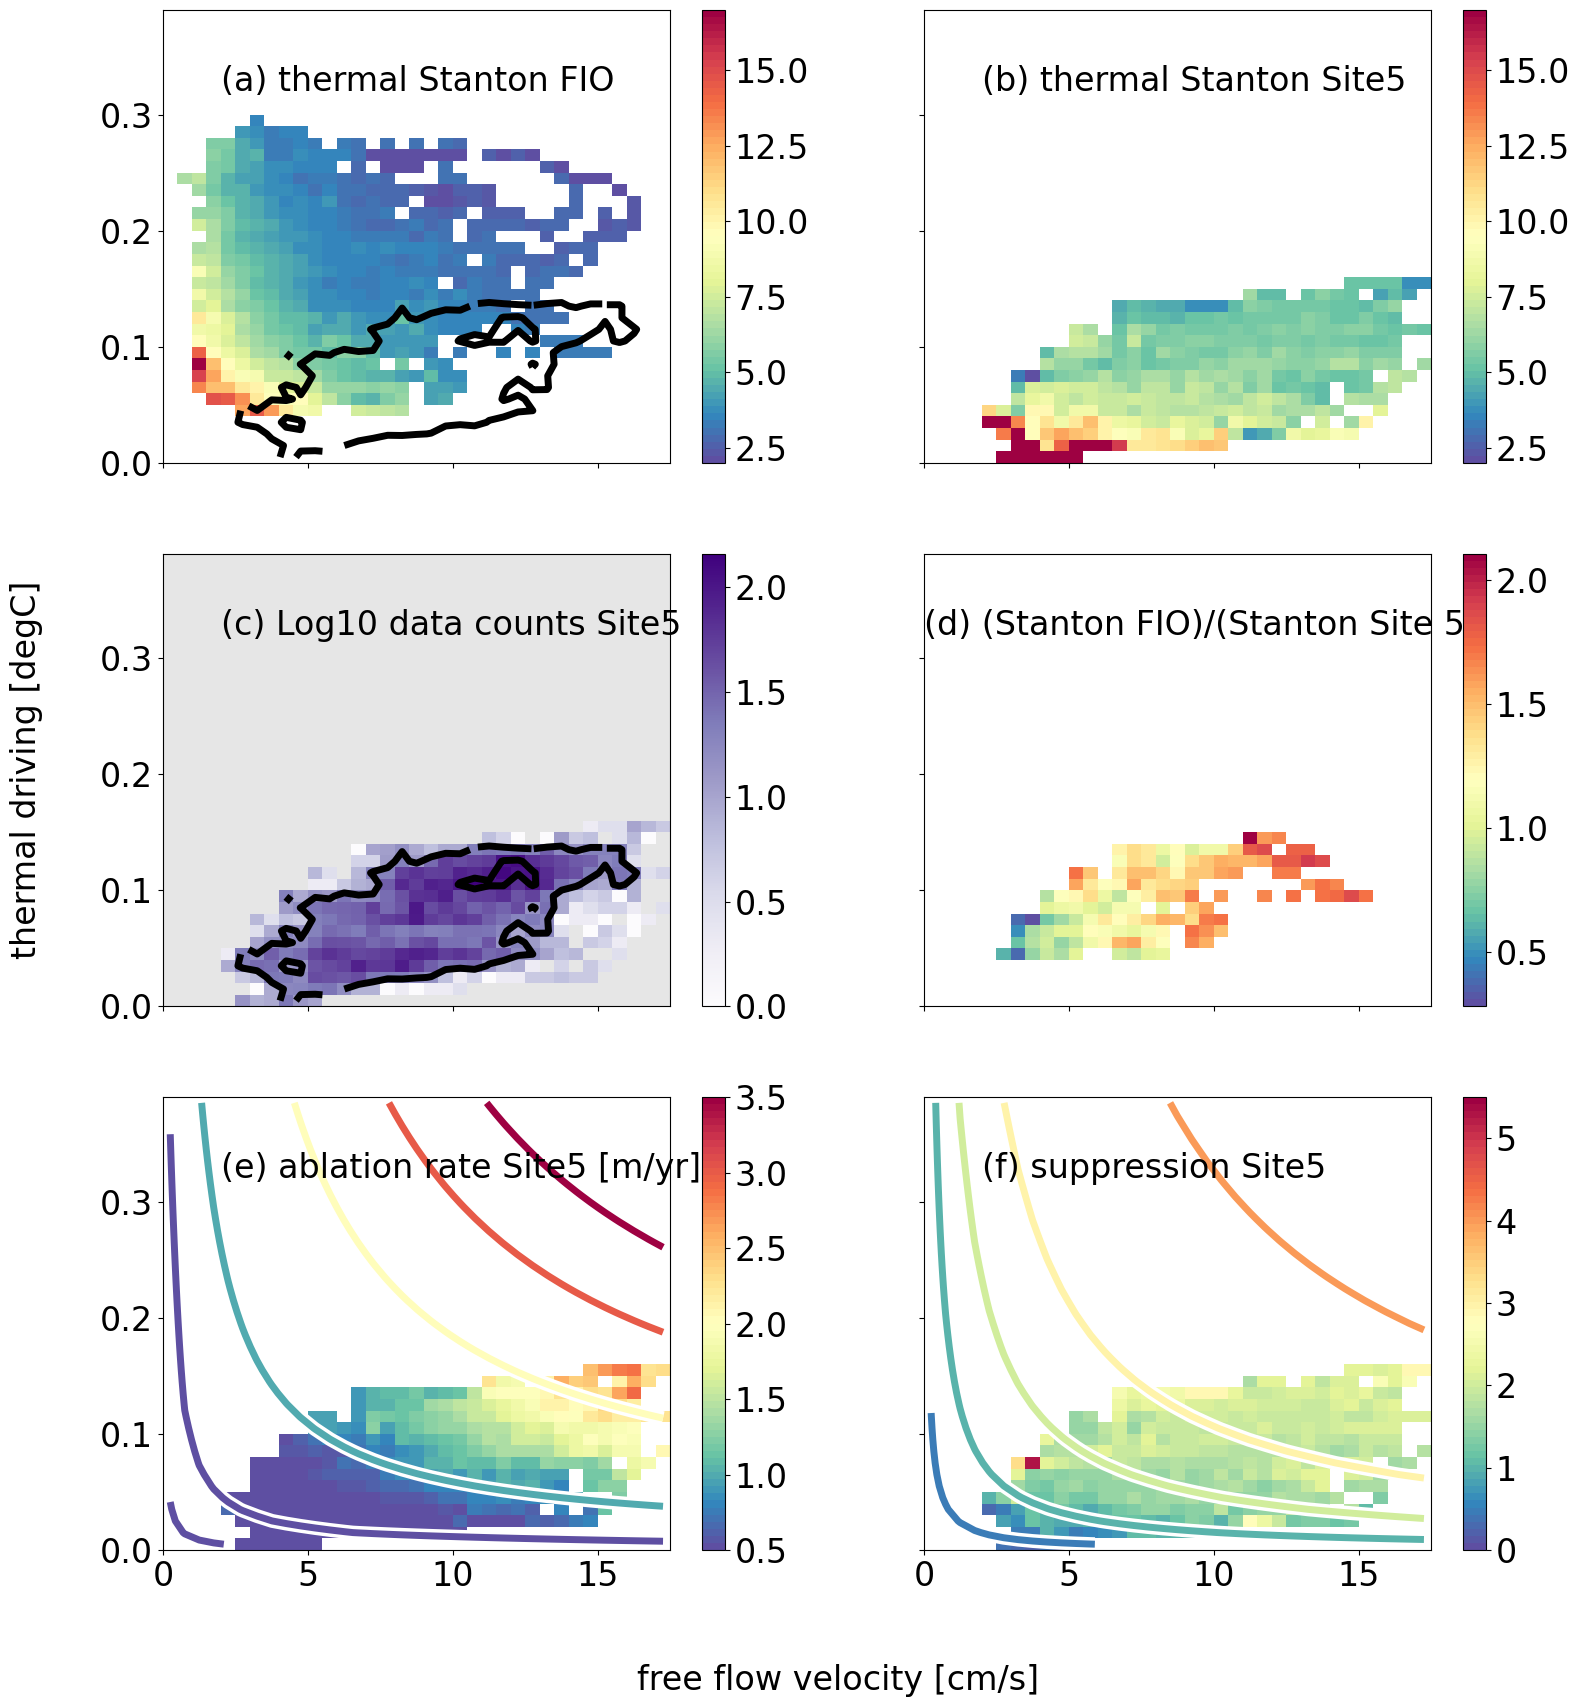

In [19]:

print('Compare Site 5 data range')

#tdbins = np.arange(0.02, 0.32, 0.01)
tdbins_s5 = np.arange(0.00, 0.4, 0.01)
ubins_s5 = np.arange(0, 0.18, 0.005)

tdi_s5 = tdbins_s5
ui_s5 = ubins_s5 # np.concatenate([np.arange(0, 0.06, 0.01), np.arange(0.06, 0.18, 0.04)])

tdim_s5 = 0.5*(tdi_s5[0:-1]+tdi_s5[1:])
uim_s5 = 0.5*(ui_s5[0:-1]+ui_s5[1:])

tdg_s5, ug_s5 = np.meshgrid(tdim_s5, uim_s5)

# FIO stats on S5 grid
CdTt_obsvss5_mean = stats.binned_statistic_2d( spd[bool], td[bool], CdTt_obs[bool], bins=[ubins_s5, tdbins_s5], statistic='mean')  # Returns a object
mm_obsvss5_mean = stats.binned_statistic_2d( spd[bool], td[bool], mm[bool], bins=[ubins_s5, tdbins_s5], statistic='mean')  # Returns a object

# S5 stats
hist_s5 = stats.binned_statistic_2d( spd_s5[:,0], td_s5[:,0], None, bins=[ubins_s5, tdbins_s5], statistic='count')  # Returns a object
hist_s5.statistic[hist_s5.statistic == 0] = np.nan  # Sets all values of 0 to nan as log10(0) = -inf
CdTt_s5_mean = stats.binned_statistic_2d( spd_s5[:,0], td_s5[:,0], CdTt_s5[:,0], bins=[ubins_s5, tdbins_s5], statistic='mean')  # Returns a object
mm_s5_mean = stats.binned_statistic_2d( spd_s5[:,0], td_s5[:,0], mm_s5[:,0], bins=[ubins_s5, tdbins_s5], statistic='mean')  # Returns a object


ss_grid_s5 = ss([tdg_s5+(gamma_1*S_w + gamma_2 + gamma_3*Pb), ug_s5],popt_melt[0],popt_melt[1],popt_melt[2],popt_melt[3])
mm_grid_s5 = dmelt_para([tdg_s5+(gamma_1*S_w + gamma_2 + gamma_3*Pb), ug_s5],popt_melt[0],popt_melt[1],popt_melt[2],popt_melt[3])

plt.rcParams.update({'font.size': 24})
fig, ax = plt.subplots(3,2, sharex=True, sharey=True, figsize=np.array([18, 20]))

plt.sca(ax[0,0])
image = plt.pcolormesh(ui_s5*100, tdi_s5, CdTt_obsvss5_mean.statistic.T*10**4, 
                       cmap=cmap, shading='flat', vmin = 2, vmax = 17) 
cnt_s5 = plt.contour(uim_s5*100, tdim_s5, np.log10(hist_s5.statistic.T),[1.2, 2],
                                       colors='k', linewidths=5.0)
fig.colorbar(image, ax=ax[0,0])
ax[0,0].text(2,.32, "(a) thermal Stanton FIO")


plt.sca(ax[0,1])
image = plt.pcolormesh(ui_s5*100, tdi_s5, CdTt_s5_mean.statistic.T*10**4, 
                       cmap=cmap, shading='flat', vmin = 2, vmax = 17) 
#cnt_s5 = plt.contour(uim_s5*100, tdim_s5, CdTt_s5_mean.statistic.T*10**4, 
#                       linewidths=5.0, vmin = 2, vmax = 17) 
#cnt_s5 = plt.contour(uim_s5*100, tdim_s5, CdTt_s5_mean.statistic.T*10**4,cnts,
#                  colors=[.4, .4, .4, 1], linewidths=5.0, vmin = 2, vmax = 17)
fig.colorbar(image, ax=ax[0,1])
ax[0,1].text(2,.32, "(b) thermal Stanton Site5")


plt.sca(ax[1,0])
ax[1,0].set_facecolor((.9, .9, .9))
image = plt.pcolormesh(ui_s5*100, tdi_s5, np.log10(hist_s5.statistic.T), cmap=cm[1], shading='flat')
cnt_s5 = plt.contour(uim_s5*100, tdim_s5, np.log10(hist_s5.statistic.T),[1.2, 2],
                                       colors='k', linewidths=5.0)
fig.colorbar(image, ax=ax[1,0])
ax[1,0].text(2,.32, "(c) Log10 data counts Site5")



plt.sca(ax[1,1])
image = plt.pcolormesh(ui_s5*100, tdi_s5, CdTt_s5_mean.statistic.T/CdTt_obsvss5_mean.statistic.T, 
                       cmap=cmap, shading='flat') 
fig.colorbar(image, ax=ax[1,1])
ax[1,1].text(0,.32, "(d) (Stanton FIO)/(Stanton Site 5)")


plt.sca(ax[2,0])
cnts = [0.1, 0.5, 1, 2, 3, 4]
image = plt.pcolormesh(ui_s5*100, tdi_s5, mm_s5_mean.statistic.T, cmap=cmap, shading='flat', vmin = 0.5, vmax = 3.5) 
plt.contour(uim_s5*100, tdim_s5, mm_grid_s5.T, cnts, colors="white", linewidths=10.0)
plt.contour(uim_s5*100, tdim_s5, mm_grid_s5.T, cnts, cmap=cmap, vmin = 0.5, vmax = 3.5, linewidths=5.0)

ax[2,0].text(2,.32, "(e) ablation rate Site5 [m/yr]")

fig.colorbar(image, ax=ax[2,0])

plt.sca(ax[2,1])
cnts = [0.5, 1, 2, 3, 4, 5]
image = plt.pcolormesh(ui_s5*100, tdi_s5, CdTt0/CdTt_s5_mean.statistic.T, cmap=cmap, shading='flat', vmin = 0, vmax = 5.5)
plt.contour(uim_s5*100, tdim_s5, ss_grid_s5.T, cnts, colors='white', linewidths=10.0)
plt.contour(uim_s5*100, tdim_s5, ss_grid_s5.T, cnts, cmap=cmap, vmin = 0, vmax = 5.5, linewidths=5.0)
fig.colorbar(image, ax=ax[2,1])

ax[2,1].text(2,.32, "(f) suppression Site5")


fig.text(0.5, 0.04, 'free flow velocity [cm/s]', ha='center')
fig.text(0.04, 0.5, 'thermal driving [degC]', va='center', rotation='vertical')


plt.savefig("../plot/gamma_dampening_distribution_S5_comparison.png",bbox_inches='tight')
plt.show

<function matplotlib.pyplot.show(close=None, block=None)>

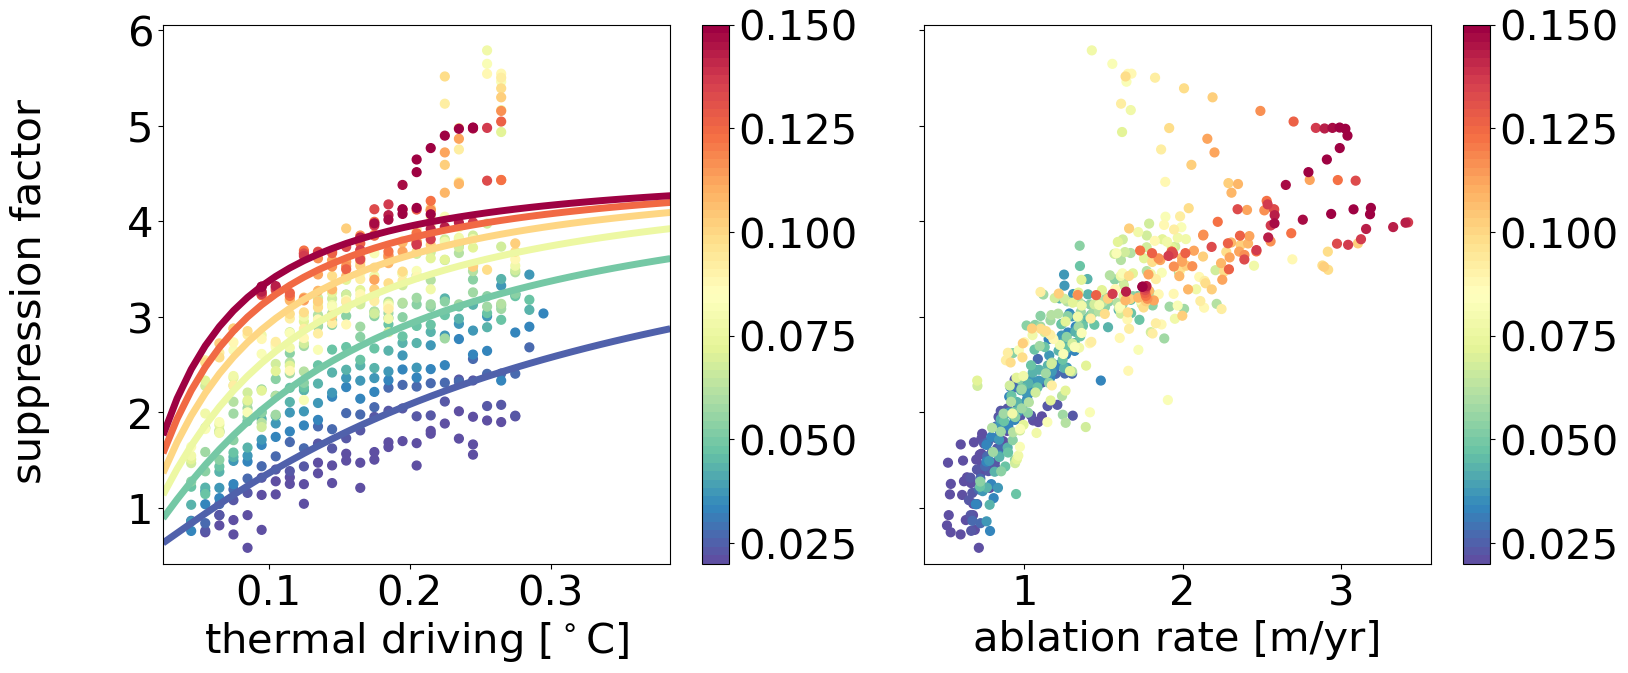

In [20]:
################### functional form

plt.rcParams.update({'font.size': 30})
fig, ax = plt.subplots(1,2, sharey=True, figsize=np.array([18, 7]))

plt.sca(ax[0])
# plt.scatter(td,(CdTt0/CdTt_obs),s=12,c=spd, cmap=cmap, vmin = 0.02, vmax = 0.12)

# plt.scatter(tdg, ss_opt_mean.statistic, s=40,c=ug, cmap=cmap, vmin = 0.02, vmax = 0.15)
sca = plt.scatter(tdg, CdTt0/CdTt_obs_mean.statistic, s=40,c=ug, cmap=cmap, vmin = 0.02, vmax = 0.15)
#plt.plot(tdg.T, ss_grid.T)
plt.contour(tdg, ss_grid, ug, cmap=cmap, vmin = 0.02, vmax = 0.15, linewidths=5.0)
fig.colorbar(sca, ax=ax[0]) # free flow velocity [cm/s]
# ax[0].set_ylabel('suppression factor')
ax[0].set_xlabel('thermal driving [$^\circ$C]')

plt.sca(ax[1])
# plt.scatter(mm, CdTt0/CdTt_obs, s=10,c=spd, cmap=cmap, vmin = 0.02, vmax = 0.15)
plt.scatter(mm_mean.statistic, CdTt0/CdTt_obs_mean.statistic, s=40,c=ug, cmap=cmap, vmin = 0.02, vmax = 0.15)
fig.colorbar(sca, ax=ax[1]) # free flow velocity [cm/s]
# ax[1].set_ylabel('suppression factor')
ax[1].set_xlabel('ablation rate [m/yr]')

fig.text(0.04, 0.5, 'suppression factor', va='center', rotation='vertical')

plt.savefig("../plot/gamma_dampening_functional_form.png",bbox_inches='tight')
plt.show


# 2-eqn. melt rate expression  
${a_b}^{2EQ} = \frac{\rho_w~c_w~{C_d}^{1/2}\Gamma_{TS}}{\rho_i \left( L_i-c_i~(T_i-T_f) \right)}~U(T_f-T_w) $, with $\Gamma_{TS}~u^* = \sqrt{C_d}\Gamma_{TS}~U$

define 3-eqn formulaiton which takes suppresion factor and constant Stanton number as input
define 2-eqn formulaiton which takes suppresion factor and constant Stanton number as input

...fitting to data...
...done

optimal Stanton numbers (3eq, 3eq_ss, 2eq, 2eq_ss):
[0.00040987]
[0.00109484]
[4.0154468e-05]
[0.00010859]

compute parameterized time series and make simple scatter plots


<function matplotlib.pyplot.show(close=None, block=None)>

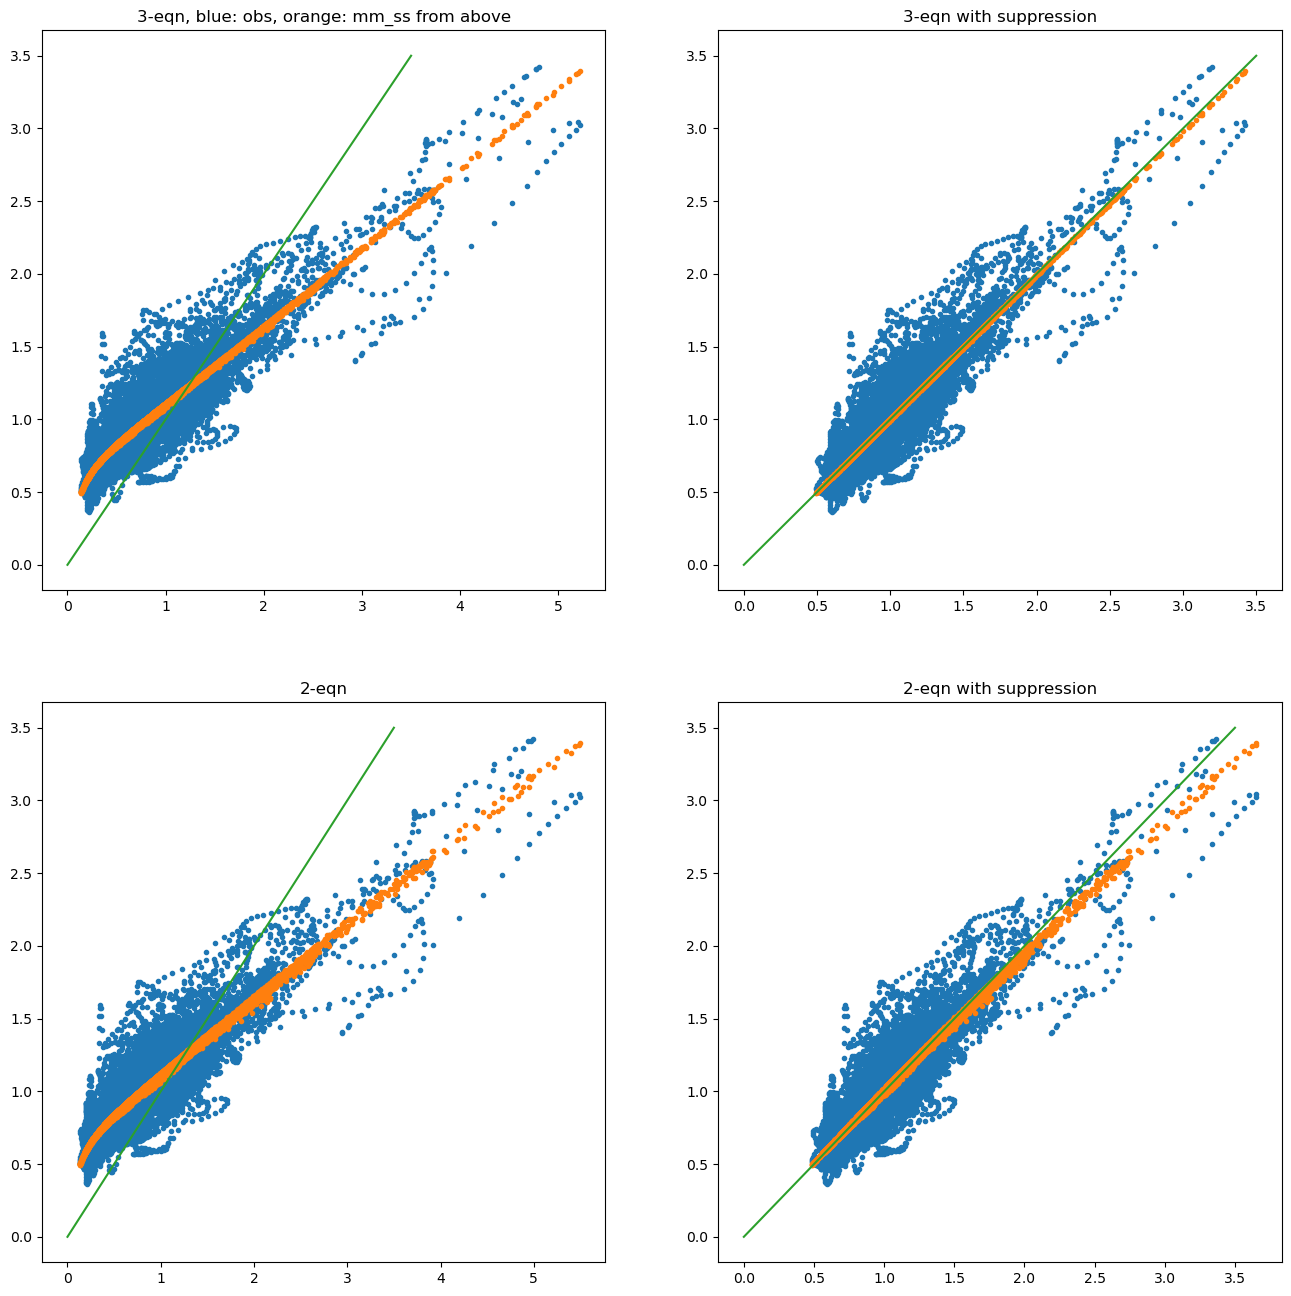

In [26]:
plt.rcParams.update({'font.size': 10})
print('define 3-eqn formulaiton which takes suppresion factor and constant Stanton number as input')
def aa_3eq(M,CdTt_in):
    aa=[]
    # time sereis input
    T = M[0] # t_in
    U = M[1] # spd_in
    ss_in = M[2] # optional dampening factor
    
    CdTt= CdTt_in/ss_in # Thermal Stanton number
    CdTs = CdTt/30 # assume constant ratio

    # Constants, Elin
    A=rho_i*L_i
    B=rho_i*c_i*T_i #
    C=rho_i*c_i  # 
    D=rho_w*c_w*CdTt
    E=rho_w*CdTs
    F=gamma_2+gamma_3*Pb

    
    aa=rho_i*(B-A-C*F)
    
    bb=E*(B-A)-C*gamma_1*S_w*E-C*F*E-D*U*F*rho_i+D*U*T*rho_i
    cc=D*U*T*E-D*U*F*E-D*U*gamma_1*S_w*E
    aa=N*(-bb-np.sqrt(bb**2-4*aa*cc))/(2*aa) # meltrate [m/yr]
    return aa

print('define 2-eqn formulaiton which takes suppresion factor and constant Stanton number as input')
print('')
def aa_2eq(M,CdTts_in):
    aa = []
    # time sereis input
    T = M[0] # t_in
    U = M[1] # spd_in
    ss_in = M[2] # optional dampening factor
    T_f = (gamma_1*S_w + gamma_2 + gamma_3*Pb)
    aa = N*(rho_w*c_w/(rho_i*c_i*(T_i-T_f)-L_i))*CdTts_in/ss_in*U*(T_f-T) # meltrate [m/yr]
    return aa

print('...fitting to data...')

p0 = CdTt0 # initial guess iptimizing 3 eqn
i_ = np.isfinite(t*spd*mm)
CdTt_opt_3eq, pcov = curve_fit(aa_3eq, [t[i_], spd[i_], ss_opt[i_]/ss_opt[i_]] , mm[i_], p0, maxfev = 12000)
CdTt_opt_3eq_ss, pcov = curve_fit(aa_3eq, [t[i_], spd[i_], ss_opt[i_]] , mm[i_], p0, maxfev = 12000)
CdTts_opt_2eq, pcov = curve_fit(aa_2eq, [t[i_], spd[i_], ss_opt[i_]/ss_opt[i_]] , mm[i_], p0, maxfev = 12000)
CdTts_opt_2eq_ss, pcov = curve_fit(aa_2eq, [t[i_], spd[i_], ss_opt[i_]] , mm[i_], p0, maxfev = 12000)
print('...done')
print('')


print('optimal Stanton numbers (3eq, 3eq_ss, 2eq, 2eq_ss):')
print(CdTt_opt_3eq)
print(CdTt_opt_3eq_ss)
print(CdTts_opt_2eq)
print(CdTts_opt_2eq_ss)
print('')

print('compute parameterized time series and make simple scatter plots')
mm_opt_3eq = aa_3eq([t, spd, ss_opt/ss_opt],CdTt_opt_3eq)
mm_opt_3eq_ss = aa_3eq([t, spd, ss_opt],CdTt_opt_3eq_ss)
mm_opt_2eq = aa_2eq([t, spd, ss_opt/ss_opt],CdTts_opt_2eq)
mm_opt_2eq_ss = aa_2eq([t, spd, ss_opt],CdTts_opt_2eq_ss)

fig, ax = plt.subplots(2,2, figsize=np.array([16,16]))
xy = [0,3.5]
ax[0,0].plot(mm_opt_3eq,mm,'.')
ax[0,0].plot(mm_opt_3eq,mm_ss,'.')
ax[0,0].plot(xy,xy)
ax[0,0].set_title('3-eqn, blue: obs, orange: mm_ss from above')

xy = [0,3.5]
ax[0,1].plot(mm_opt_3eq_ss,mm,'.')
ax[0,1].plot(mm_opt_3eq_ss,mm_ss,'.')
ax[0,1].plot(xy,xy)
ax[0,1].set_title('3-eqn with suppression')

xy = [0,3.5]
ax[1,0].plot(mm_opt_2eq,mm,'.')
ax[1,0].plot(mm_opt_2eq,mm_ss,'.')
ax[1,0].plot(xy,xy)
ax[1,0].set_title('2-eqn')

xy = [0,3.5]
ax[1,1].plot(mm_opt_2eq_ss,mm,'.')
ax[1,1].plot(mm_opt_2eq_ss,mm_ss,'.')
ax[1,1].plot(xy,xy)
ax[1,1].set_title('2-eqn with suppression')
plt.show


T_f
-2.1477049999999998
CdTts_opt_2eq
[4.0154468e-05]


Text(0.5, 1.0, 'mm_opt_2eq/(spd*(t-T_f)); melt rate relates with constant factor')

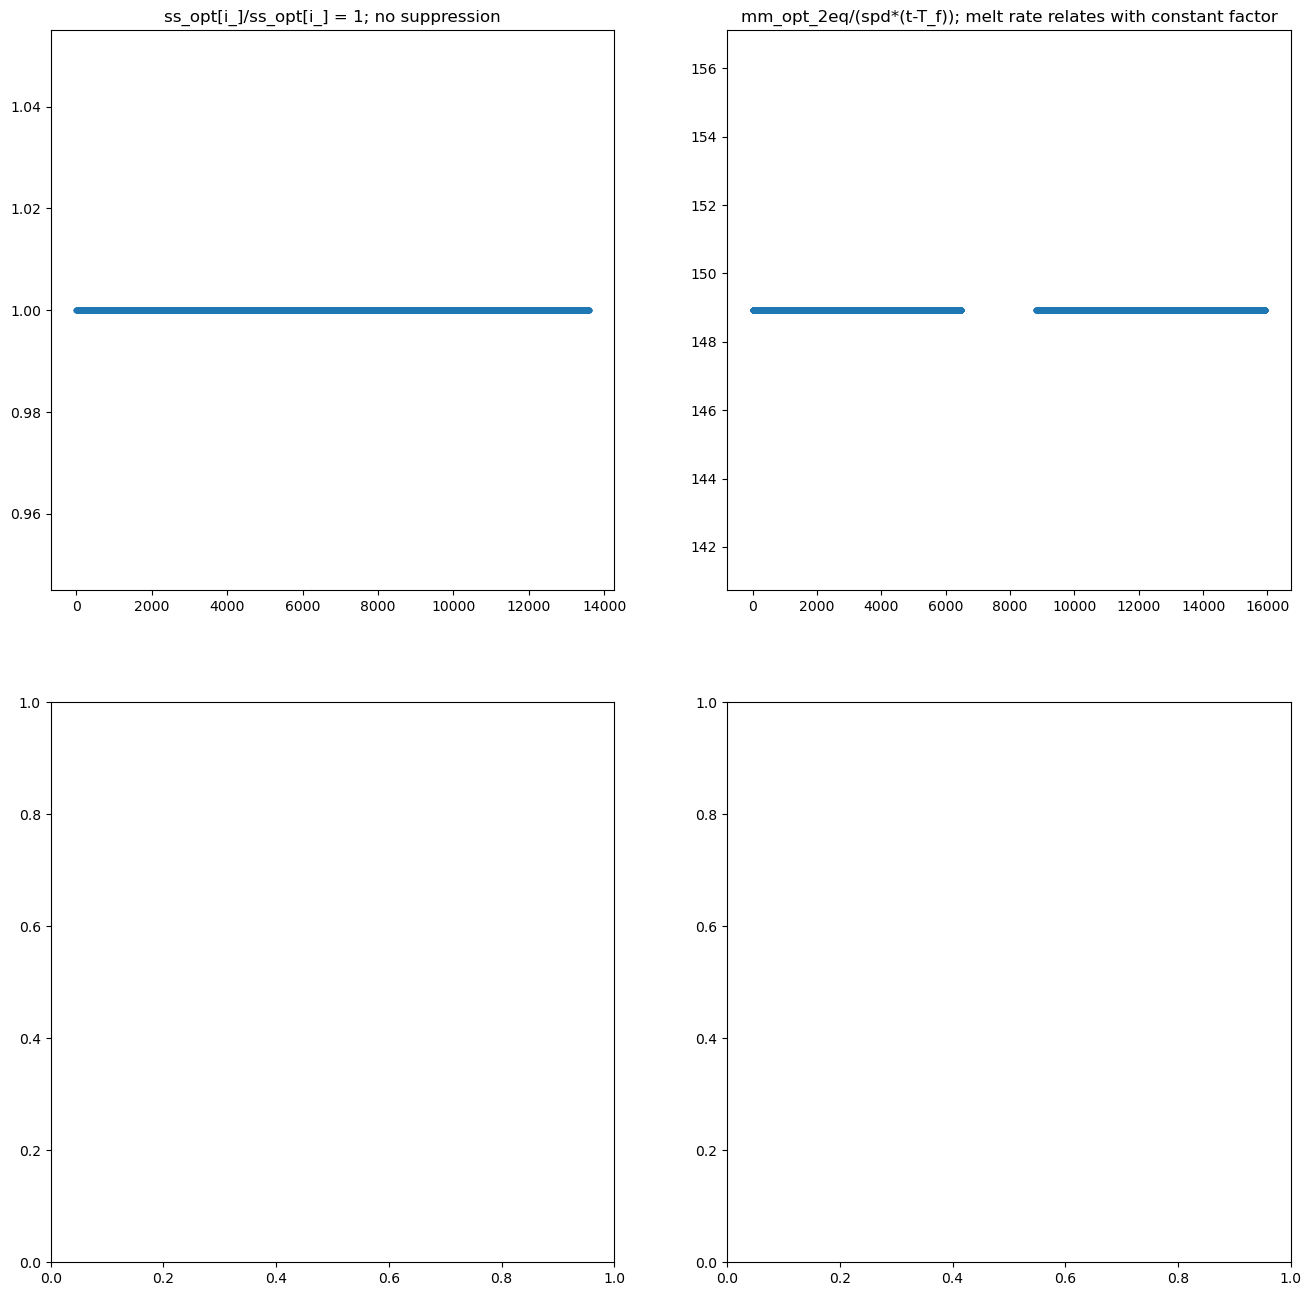

In [51]:


# This is how I computed the melt rate:
#
#def aa_2eq(M,CdTts_in):
#    aa = []
#    # time sereis input
#    T = M[0] # t_in
#    U = M[1] # spd_in
#    ss_in = M[2] # optional dampening factor
#    T_f = (gamma_1*S_w + gamma_2 + gamma_3*Pb)
#    aa = N*(rho_w*c_w/(rho_i*c_i*(T_i-T_f)-L_i))*CdTts_in/ss_in*U*(T_f-T) # meltrate [m/yr]
#    return aa
#
# mm_opt_2eq = aa_2eq([t, spd, ss_opt/ss_opt],CdTts_opt_2eq)

ss_opt[i_]/ss_opt[i_]

T_f = (gamma_1*S_w + gamma_2 + gamma_3*Pb)

const = mm_opt_2eq/(spd*(t-T_f))

print('T_f')
print(T_f)
print('CdTts_opt_2eq')
print(CdTts_opt_2eq)

fig, ax = plt.subplots(2,2, figsize=np.array([16,16]))
xy = [0,3.5]
ax[0,0].plot(ss_opt[i_]/ss_opt[i_],'.')
ax[0,0].set_title('ss_opt[i_]/ss_opt[i_] = 1; no suppression')

ax[0,1].plot(const,'.')
ax[0,1].set_title('mm_opt_2eq/(spd*(t-T_f)); melt rate relates with constant factor')

#ax[0,1].plot(const,'.')




In [ ]:
# 2d histograms of data distribution
# cmap = plt.cm.get_cmap('Spectral_r', 64)
mbins  = np.arange(-0.1, 3.5, 0.05)
ll = [0, 3.5]
al = 0.5

ii = np.isfinite(t*spd*mm)


# qunatiles for quant-quant plot
qts = np.arange(0.001, 0.999, 0.001) 
qmmq = np.quantile(mm[ii],qts)
qmmq_opt_3eq = np.quantile(mm_opt_3eq[ii],qts)
qmmq_opt_3eq_ss = np.quantile(mm_opt_3eq_ss[ii],qts)
qmmq_opt_2eq = np.quantile(mm_opt_2eq[ii],qts)
qmmq_opt_2eq_ss = np.quantile(mm_opt_2eq_ss[ii],qts)
qmmq_reg = np.quantile(mm_reg[ii],qts)

# initailize figure
plt.rcParams.update({'font.size': 18})
fig,ax=plt.subplots(2,2)
fig.set_figwidth(10)
fig.set_figheight(10)
ins_loc = [0.58,0.02,0.4,0.4]
#r2_loc = [0.2, 3]
r2_loc = [0.05, 3.3]
d2l = 0.3
r2_loci = [0.58, 0.02]
lgs = 14

##############################
ax[0,1].set(autoscale_on=False, adjustable="box", aspect='equal', xlim=ll, ylim=ll)
plt.sca(ax[0,1]) 
hist = stats.binned_statistic_2d(mm_opt_3eq[ii], mm[ii], None, bins=[mbins, mbins], statistic='count')  # Returns a object
hist.statistic[hist.statistic == 0] = np.nan  # Sets all values of 0 to nan as log10(0) = -inf
image = plt.pcolormesh(mbins, mbins, np.log10(hist.statistic.T), cmap=cmap, shading='flat') 
ax[0,1].plot(ll,ll,'k')
plt.text(r2_loc[0],  r2_loc[1],  '(b) 3-EQN, constant Stanton No.', fontsize = lgs)
plt.text(r2_loc[0],  r2_loc[1] - 2*d2l, '$r^2 = $ ' + str(round(r2_score_man(mm[ii], mm_opt_3eq[ii]),2)) , fontsize = lgs)
plt.text(r2_loc[0],  r2_loc[1] - d2l, 
         '$\sqrt{C_d}\Gamma_{T} = $ ' + str(round(10**4*CdTt_opt_3eq[0],1)) + '$\\times 10^{-4}$',
        fontsize = lgs)
plt.setp(ax, xticks=[1, 2, 3],  yticks=[1, 2, 3])

ins0 = ax[0,1].inset_axes(ins_loc, xlim=(ll[0], ll[1]), ylim=(ll[0], ll[1]), xticklabels=[], yticklabels=[], xticks=[], yticks=[])
ins0.set_aspect('equal', adjustable="datalim")
ins0.plot(qmmq_opt_3eq, qmmq,'.',color="C{}".format(1))
ins0.plot(ll,ll,'k',color="C{}".format(0))
ins0.text(r2_loci[0],  r2_loci[1], '$r^2 = $ ' + str(round(r2_score_man(qmmq_opt_3eq, qmmq),2)) , fontsize = lgs)
ins0.patch.set_alpha(al)

############################
ax[0,0].set(autoscale_on=False, adjustable="box", aspect='equal', xlim=ll, ylim=ll)
plt.sca(ax[0,0]) 
hist = stats.binned_statistic_2d( mm_opt_3eq_ss[ii], mm[ii], None, bins=[mbins, mbins], statistic='count')  # Returns a object
hist.statistic[hist.statistic == 0] = np.nan  # Sets all values of 0 to nan as log10(0) = -inf
image = plt.pcolormesh(mbins, mbins, np.log10(hist.statistic.T), cmap=cmap, shading='flat') 
ax[0,0].plot(ll,ll,'k')
plt.text(r2_loc[0],  r2_loc[1],  '(a) 3-EQN with suppression', fontsize = lgs)
plt.text(r2_loc[0],  r2_loc[1] - 2*d2l, '$r^2 = $ ' + str(round(r2_score_man(mm[ii], mm_opt_3eq_ss[ii]),2)) , fontsize = lgs)
plt.text(r2_loc[0],  r2_loc[1] - d2l, 
         '$\sqrt{C_d}\Gamma_{T} = $ ' + str(round(10**4*CdTt_opt_3eq_ss[0],1)) + '$\\times 10^{-4}$',
        fontsize = lgs)

ins1 = ax[0,0].inset_axes(ins_loc, xlim=(ll[0], ll[1]), ylim=(ll[0], ll[1]), xticklabels=[], yticklabels=[], xticks=[], yticks=[])
ins1.set_aspect('equal', adjustable="datalim")
ins1.plot(qmmq_opt_3eq_ss, qmmq,'.',color="C{}".format(1))
ins1.plot(ll,ll,'k',color="C{}".format(0))
ins1.text(r2_loci[0],  r2_loci[1], '$r^2 = $ ' + str(round(r2_score_man(qmmq_opt_3eq_ss, qmmq),2)) , fontsize = lgs)
ins1.patch.set_alpha(al)

##############################
ax[1,1].set(autoscale_on=False, adjustable="box", aspect='equal', xlim=ll, ylim=ll)
plt.sca(ax[1,1]) 
hist = stats.binned_statistic_2d(mm_reg[ii], mm[ii], None, bins=[mbins, mbins], statistic='count')  # Returns a object
hist.statistic[hist.statistic == 0] = np.nan  # Sets all values of 0 to nan as log10(0) = -inf
image = plt.pcolormesh(mbins, mbins, np.log10(hist.statistic.T), cmap=cmap, shading='flat') 
ax[1,1].plot(ll,ll,'k')
plt.text(r2_loc[0],  r2_loc[1],  '(d) optimal regression, $a_b = $', fontsize = lgs)
plt.text(r2_loc[0],  r2_loc[1] - d2l,  str(round(reg.slope,1)) + '$({\Delta{T}}^{0.63}~u^{0.74}) +$' + str(round(reg.intercept,2)), fontsize = lgs)
plt.text(r2_loc[0],  r2_loc[1] - 2*d2l, '$r^2 = $ ' + str(round(r2_score_man(mm[ii], mm_reg[ii]),2)) , fontsize = lgs)
#plt.text(r2_loc[0],  r2_loc[1] - 2*d2l, 
#         '$\sqrt{C_d}\Gamma_{TS} = $ ' + str(round(10**5*CdTts_opt_2eq[0],1)) + '$\\times~10^{-5}$',
#        fontsize = lgs)

ins0 = ax[1,1].inset_axes(ins_loc, xlim=(ll[0], ll[1]), ylim=(ll[0], ll[1]), xticklabels=[], yticklabels=[], xticks=[], yticks=[])
ins0.set_aspect('equal', adjustable="datalim")
ins0.plot(qmmq_reg, qmmq,'.',color="C{}".format(1))
ins0.plot(ll,ll,'k',color="C{}".format(0))
ins0.text(r2_loci[0],  r2_loci[1], '$r^2 = $ ' + str(round(r2_score_man(qmmq_reg, qmmq),2)) , fontsize = lgs)
ins0.patch.set_alpha(al)

############################
ax[1,0].set(autoscale_on=False, adjustable="box", aspect='equal', xlim=ll, ylim=ll)
plt.sca(ax[1,0]) 
hist = stats.binned_statistic_2d( mm_opt_2eq_ss[ii], mm[ii], None, bins=[mbins, mbins], statistic='count')  # Returns a object
hist.statistic[hist.statistic == 0] = np.nan  # Sets all values of 0 to nan as log10(0) = -inf
image = plt.pcolormesh(mbins, mbins, np.log10(hist.statistic.T), cmap=cmap, shading='flat') 
ax[1,0].plot(ll,ll,'k')
plt.text(r2_loc[0],  r2_loc[1],  '(c) 2-EQN with suppression', fontsize = lgs)
plt.text(r2_loc[0],  r2_loc[1] - 2*d2l, '$r^2 = $ ' + str(round(r2_score_man(mm[ii], mm_opt_2eq_ss[ii]),2)) , fontsize = lgs)
plt.text(r2_loc[0],  r2_loc[1] - d2l, 
         '$\sqrt{C_d}\Gamma_{TS} = $ ' + str(round(10**5*CdTts_opt_2eq_ss[0])) + '$\\times 10^{-5}$',
        fontsize = lgs)

ins1 = ax[1,0].inset_axes(ins_loc, xlim=(ll[0], ll[1]), ylim=(ll[0], ll[1]), xticklabels=[], yticklabels=[], xticks=[], yticks=[])
ins1.set_aspect('equal', adjustable="datalim")
ins1.plot(qmmq_opt_2eq_ss, qmmq,'.',color="C{}".format(1))
ins1.plot(ll,ll,'k',color="C{}".format(0))
ins1.text(r2_loci[0],  r2_loci[1], '$r^2 = $ ' + str(round(r2_score_man(qmmq_opt_2eq_ss, qmmq),2)) , fontsize = lgs)
ins1.patch.set_alpha(al)

# # # # #
plt.subplots_adjust(wspace=0.05, hspace=0.05, right=0.85)
for ax_ in ax.flat:
    ax_.label_outer()

cbar_ax = fig.add_axes([0.87, 0.2, 0.025, 0.6])
fig.colorbar(image, cax=cbar_ax)

fig.text(0.5, 0.04, 'parameterized ablation rate [m/yr]', ha='center')
fig.text(0.04, 0.5, 'observed ablation rate [m/yr]', va='center', rotation='vertical')

plt.savefig("../plot/melt_distribution.png", bbox_inches='tight')
plt.show()

print('Fix legend for regression:')
print(str(round(result_reg.x[0],2)))
print(str(round(result_reg.x[1],2)))

In [ ]:
print('prepare time series plot (Fig 1)')
# FIXME, dates: https://docs.python.org/3/library/datetime.html
# http://jmlilly.net/course/labs/html/VarianceEllipses-Python.html
# http://jmlilly.net/course/labs/html/DistributionalAnalysis-Python.html

print('melt rate errors from residual:')
mm_err = np.nanstd(mm_opt_3eq_ss-mm)
print(str(mm_err))
print

fig, ax = plt.subplots(4,1, sharex=True, gridspec_kw={'height_ratios': [2, 1, 1, 1]}, figsize=np.array([16,16]))
ax[0].plot(num,mm,label="observations")
ax[0].plot(num,mm_opt_3eq_ss,label="3-EQN with suppresssion")
#ax[0].fill_between(num, mm_opt_3eq_ss-mm_err, mm_opt_3eq_ss+mm_err, alpha=0.7)
ax[0].fill_between(num, (num-num)-mm_err, (num-num)+mm_err, alpha=0.2)
#ax[0].plot(num,mm_opt_3eq_ss-mm,label="3-EQN - obs, std = " + str(round(mm_err,2)) + " [m/yr]")
ax[0].plot(num,mm_opt_3eq_ss-mm,label="3-EQN - observations")
ax[0].plot(num,mm_reg-mm_opt_3eq_ss,label="regression - 3-EQN")
ax[0].plot(num,mm_opt_2eq_ss-mm_opt_3eq_ss,label="2-EQN - 3-EQN")
plt.sca(ax[0])
plt.axhline(y = 0, color = 'k', linestyle = '-')
plt.legend(loc="upper center")
ax[0].set_ylabel('ablation rate [m/yr]')

ax[1].plot(num,CdTt_obs*10**4, label = 'observed')
ax[1].plot(num,CdTt0/ss_opt*10**4, label = 'parameterized')
ax[1].set_ylabel('$\\times10^4{C_d}^{1/2}\Gamma_T$')
plt.sca(ax[1])
plt.legend(loc="upper right")
plt.axhline(y = 11, color = 'k', linestyle = '--')

ax[2].plot(num,t,label="observations")
plt.sca(ax[2])
plt.axhline(y = np.nanmean(t), color = 'k', linestyle = '-')
ax[2].set_ylabel('Temperature [$^\circ$C]')

ax[3].plot(num,spd*100,label="observations")
plt.sca(ax[3])
plt.axhline(y = np.nanmean(spd*100), color = 'k', linestyle = '-')
ax[3].set_ylabel('Speed [cm/s]')
ax[3].set_xlabel('Datenum')

plt.savefig("../plot/melt_time_series.png", bbox_inches='tight')
plt.show
#y0 = np.exp(2 + 3*x - 7*x**3)
#y1 = 7-4*np.sin(4*x)
#plt.plot(x,y0,x,y1)
#plt.gca().legend(('y0','y1'))


In [ ]:
print('prepare time series plot 3eqn vs others')
# FIXME, dates: https://docs.python.org/3/library/datetime.html
# http://jmlilly.net/course/labs/html/VarianceEllipses-Python.html
# http://jmlilly.net/course/labs/html/DistributionalAnalysis-Python.html


fig, ax = plt.subplots(3,1, sharex=True, gridspec_kw={'height_ratios': [2, 2, 2]}, figsize=np.array([16,20]))
ax[0].plot(num,mm,label="observations")
ax[0].plot(num,mm_opt_3eq_ss,label="3-EQN with suppresssion")
plt.sca(ax[0])
plt.axhline(y = 0, color = 'k', linestyle = '-')
plt.legend(loc="upper center")
ax[0].set_ylabel('ablation rate [m/yr]')

ax[1].plot(num,mm,label="observations")
ax[1].plot(num,mm_opt_3eq,label="native 3-EQN")
plt.sca(ax[1])
plt.axhline(y = 0, color = 'k', linestyle = '-')
plt.legend(loc="upper center")
ax[1].set_ylabel('ablation rate [m/yr]')

ax[2].plot(num,mm,label="observations")
ax[2].plot(num,mm_opt_2eq,label="native 2-EQN")
plt.sca(ax[2])
plt.axhline(y = 0, color = 'k', linestyle = '-')
plt.legend(loc="upper center")
ax[2].set_ylabel('ablation rate [m/yr]')


**Viscous Obukov scale from Josephine, who followed the approach from Rosevear et al. 2022**  
$L_{+} = L_{Ob}/\delta_{\nu}$, with $L_{Ob} = -{u^*}^3/(k B_b)$, and $\delta_{\nu} =\nu/u^*$, and friction velocity estimated from $u^* = \sqrt{C_d}U$. Buoyancy flux is given by $g(\alpha\kappa_T(dT/dz)_b-\beta\kappa_S(dS/dz)_b)$. Inferring interfacial gradients from three-equation model, the buoyancy flux becomes $B_b = g[\alpha(\rho_i~L_f~m)/(c_w~\rho_w)-\beta(\rho_i~S_b~m)/(\rho_w)]$.

Need to diagnose $S_b$ from 3eqn. formulation, which relies on an estimate of $\Gamma_S$:  
$S_b = (\rho_w~u^*~\Gamma_S~S_w)/(\rho_i~a_b+\rho_w~u^*~\Gamma_S)$

**Regimes, as described in Rosevear et al. 2022**  
As well as DC, stratified, and well-mixed ISOBL regimes, we depict two regimes of melting: Transient melting for $L_{+}< 2500$ and steady $L_{+}> 2500$. Within the steady melting regime we also delineate an area of reduced heat transfer for melting for $2500< L_{+}< 25000$ in which heat and salt transfer have a functional dependence on $L_{+}$.

**Typo in Maddies paper:**  
On page 2602, it is discussed that *To characterize the well-mixed to stratified transition, we solve for the stratification parameter ($\mu$), where stratified conditions are expected for $\mu\leq1$.*   However, on page 2592, the paper defines the stratification parameter as $\gamma = N^2/f^2$, while $\mu = u^*/(fL)$ is introduced as stability parameter, with a definition on the same page, upper right column below eqn. 10; The Obukov length is defined as; $L=\frac{-{u^*}^3}{kB_b}$ and k being the von Karman constant (0.4). From the context it seems that the stability parameter is used.

**Drag coefficient:**  
Constant drag is a reasonable approximation for Maddies results in the well-mixed regime, $Cd$ depends on the stability parameter. As a result, in the stratified regime, friction velocity
will be overestimated in melting parameterizations, contributing to an overestimation of melt rates.

**Asymptotic values for infinte $L_{+}$**  
$\Gamma_T = 0.012$  
$\Gamma_S = 3.9\times10^{-4}$

In [ ]:
print('L+ scale diagnostics')
print('more constants')
g = 9.81 # gravity
alpha = 3.8*10**-5 # kg per degC thermal expansion coeff
beta = 7.8*10**-4 # kg per g salt haline contraction coefficient
nu = 2*10**-6 # saltwater molecular viscosity

print('salt transfer and interface salinity')
#gams = mm_opti_td_gam/30
gams = CdTt_obs/35
ustar = Cd**(1/2)*spd
#S_b = (rho_w*ustar*S_w) / (rho_i*mm[:,0]/N + rho_w*ustar*gams)

S_b = ((rho_w*ustar*gams) / (rho_w*ustar*gams + rho_i *mm/N) ) * S_w

print('buoyancy flux')
bf = (g*(alpha*(rho_i*L_i*mm/N)/(c_w*rho_w)) - g*(beta*(rho_i*S_b*mm/N)/rho_w))

print('Obukov Length adn L+ scale')
L = -ustar**3/(0.4*bf)
dnu = (nu/ustar)

Lplus = L/dnu

print('stability parameter')
stab_para = ustar/(1.3*10**-3*L)

In [ ]:
fig, ax = plt.subplots(4, sharex=True, figsize=np.array([18, 12]))
ax[0].plot(num,mm)
plt.sca(ax[0])
plt.ylabel("melting")

ax[1].plot(num,bf)
plt.sca(ax[1])
plt.ylabel("buoyancy flux")

ax[2].plot(num,S_b)
plt.sca(ax[2])
plt.ylabel("interface salinity")

ax[3].plot(num,Lplus)
plt.sca(ax[3])
plt.ylabel("L+")
plt.yscale('log')

plt.axhline(y = 25000, color = 'g', linestyle = '-')
plt.axhline(y = 2500, color = 'r', linestyle = '-')
plt.axhline(y = 250, color = 'b', linestyle = '-')

fig.tight_layout()
plt.savefig("../plot/Lplus_series.png", bbox_inches='tight')
plt.show

In [ ]:
fig, ax = plt.subplots(1,2, figsize=np.array([16, 8]))
ax[0].plot(Lplus,CdTt_obs*10**3,'.')
plt.sca(ax[0])
plt.xscale('linear')
plt.ylabel("$10^3 \\times St$")
plt.xlabel("$L+$")
plt.axvline(x = 250, color = 'C1', linestyle = '--')
plt.axvline(x = 2500, color = 'C1', linestyle = '--')
plt.axvline(x = 25000, color = 'C1', linestyle = '--')

ax[1].plot(Lplus,CdTt_obs*10**3,'.')
plt.sca(ax[1])
plt.xscale('log')
plt.ylabel("$10^3 \\times St$")
plt.xlabel("$L+$")
plt.axvline(x = 250, color = 'C1', linestyle = '--')
plt.axvline(x = 2500, color = 'C1', linestyle = '--')
plt.axvline(x = 25000, color = 'C1', linestyle = '--')

fig.tight_layout()
plt.savefig("../plot/Lplus_St.png", bbox_inches='tight')
plt.show

In [ ]:
fig, ax = plt.subplots(1,3, figsize=np.array([18, 6]))
ax[0].plot(mm,np.log10(Lplus),'.')
plt.sca(ax[0])
plt.axhline(y = np.log10(25000), color = 'g', linestyle = '-')
plt.axhline(y = np.log10(2500), color = 'r', linestyle = '-')
plt.title("L+ against meltrate")

ax[1].plot(bf,np.log10(Lplus),'.')
plt.sca(ax[1])
plt.axhline(y = np.log10(25000), color = 'g', linestyle = '-')
plt.axhline(y = np.log10(2500), color = 'r', linestyle = '-')
plt.title("L+ against bouancy flux")

ax[2].plot(S_b,np.log10(Lplus),'.')
plt.sca(ax[2])
plt.axhline(y = np.log10(25000), color = 'g', linestyle = '-')
plt.axhline(y = np.log10(2500), color = 'r', linestyle = '-')
plt.show
plt.title("L+ against interface salinity")

fig.tight_layout()
plt.savefig("../plot/Lplus_metrics_1.png", bbox_inches='tight')
plt.show
####################

fig, ax = plt.subplots(1,3, figsize=np.array([18, 6]))
#ax[0].plot(ustar,np.log10(Lplus),'.')
plt.sca(ax[0])
plt.scatter(ustar,np.log10(Lplus),s=12,c=t+2.15)
plt.axhline(y = np.log10(25000), color = 'g', linestyle = '-')
plt.axhline(y = np.log10(2500), color = 'r', linestyle = '-')
plt.title("L+ against ustar")

#ax[1].plot(t+2.15,np.log10(Lplus),'.')
plt.sca(ax[1])
plt.scatter(t+2.15,np.log10(Lplus),s=12,c=ustar)
plt.axhline(y = np.log10(25000), color = 'g', linestyle = '-')
plt.axhline(y = np.log10(2500), color = 'r', linestyle = '-')
plt.title("L+ against thermal driving")

#ax[2].plot(gams,np.log10(Lplus),'.')
plt.sca(ax[2])
plt.scatter(gams,np.log10(Lplus),s=12,c=t+2.15)
plt.axhline(y = np.log10(25000), color = 'g', linestyle = '-')
plt.axhline(y = np.log10(2500), color = 'r', linestyle = '-')
plt.title("L+ against Gamma_S")

fig.tight_layout()
plt.savefig("../plot/Lplus_metrics_2.png", bbox_inches='tight')
plt.show

####################

fig, ax = plt.subplots(1,3, figsize=np.array([18, 6]))
#ax[0].plot(ustar,np.log10(Lplus),'.')
plt.sca(ax[0])
plt.scatter(ustar,stab_para,s=12,c=t+2.15)
#plt.axhline(y = np.log10(2500), color = 'r', linestyle = '-')
plt.title("\mu against ustar")

#ax[1].plot(t+2.15,np.log10(Lplus),'.')
plt.sca(ax[1])
plt.scatter(t+2.15,stab_para,s=12,c=ustar)
#plt.axhline(y = np.log10(2500), color = 'r', linestyle = '-')
plt.title("\mu against thermal driving")

#ax[2].plot(gams,np.log10(Lplus),'.')
plt.sca(ax[2])
plt.scatter(stab_para,gams,s=12,c=t+2.15)
# plt.axhline(y = np.log10(2500), color = 'r', linestyle = '-')
plt.title("\mu against Gamma_S")

fig.tight_layout()
plt.savefig("../plot/Lplus_metrics_3.png", bbox_inches='tight')
plt.show


In [ ]:
# material constans from Jenkins
# rho_i=916
# L_i=334000
# rho_ic_i_k_i=2.1
# rho_w=1030
# c_w=3974
# c_i=2108 # from internet, not in Jenkins tables

# freezing point linearizaion, Tf = gamma_1 * S + gamma_2 + gamma_3 * P
# gamma_1=-0.0573
# gamma_2=0.0832
# gamma_3=-7.53*10**-4

# used here, but defined and overwritten later
# CdTt=0.0011 # Thermal Stanton
# CdTs=3.1*10**-5 # Diffusion Stanton number

# CdTts=5.9*10**-4 # Stanton number - not used?
# Cd=0.0097 # not used

# Tt=0.011 # not used
# Ts=3.1*10**-4 # not used
 #Tts=0.006 #  not used

# Ice shelf values
# print('FIXME: check ice shelf values...')
# T_i=0 #-20 # internal ice temperature for conduction
# S_w=34.4 # ambient seawater
# Pb=340 # 360 # ice basse pressure

Above is the figure that illustrates how the different parameterizations are able to capture the observed melt rate variability. The regression is shown for the linear relationship of U and T, to illustrate the "compression effect" on the data (quantiles bending/ sloping away from 45deg line), whereas the solution with sub-linear response to U and T gives a very similar result as the other non-linear parameterizations.

Below are the time series (not tidy/ beautiful yet) of the observed (blue) and parameterized (orange) melt and their residuals (parameterized minus observed = green). Maybe not all panels need to go into the main part of the paper, but an overview should at least be in the appendix and a selection in the paper. Maybe the ones that we use for the melt rate parameterization, but at least the version with varying $\Gamma_T$, as we perform further analysis on it.

The stuff below here is for processing the full-length ocean time series and parameterizing melt rates "backward" in time. So far, I only saved the data in a format for Elin to work with the time-scale analysis, but we also need to decide how to incorporate/ represent the melt rate errors that come put of this.

In [ ]:
print('Load full ocean time series for long-term parameterization')

print('Read full M2 ocean data...')
#f = h5py.File('fio_m2_old4.mat','r')
f = h5py.File('fio_m2_old_10med.mat','r')
print(f.keys())

num_full = np.array(f.get('num')).T
spd_full = np.array(f.get('spd')).T
t_full = np.array(f.get('t')).T
spdf36_full = np.array(f.get('spdf36')).T
tf36_full = np.array(f.get('tf36')).T

# filtering from http://jmlilly.net/course/labs/html/VarianceEllipses-Python.html
# window = sg.windows.hann(24)      #24-point hanning window
# window = window / np.sum(window)  #normalized to sum to unity
# fcvr =  si.convolve(cvr[:,3], window, mode="mirror")  #filtered version of velocity at deepest depth

#note I'm using convolution from the image rather than the signal package because the former
#allows nicer handling of the boundary condition.  When working with a 2D array of time series, 
#you'll want to use the signal version 

# freezing point
tfr = (gamma_1*S_w + gamma_2 + gamma_3*Pb)


In [ ]:
x = (t_full-(gamma_1*S_w + gamma_2 + gamma_3*Pb))**result_reg.x[0] * (spd_full**result_reg.x[1])
mm_full = reg.slope * x + reg.intercept

x = (tf36_full-(gamma_1*S_w + gamma_2 + gamma_3*Pb))**result_reg.x[0] * (spdf36_full**result_reg.x[1])
mmf36_full = reg.slope * x + reg.intercept

x = (t_full/t_full*np.nanmean(t_full)-(gamma_1*S_w + gamma_2 + gamma_3*Pb))**result_reg.x[0] * (spd_full**result_reg.x[1])
mm_const_t = reg.slope * x + reg.intercept

x = (tf36_full/tf36_full*np.nanmean(tf36_full)-(gamma_1*S_w + gamma_2 + gamma_3*Pb))**result_reg.x[0] * (spdf36_full**result_reg.x[1])
mmf36_const_t = reg.slope * x + reg.intercept

x = (t_full-(gamma_1*S_w + gamma_2 + gamma_3*Pb))**result_reg.x[0] * ((spd_full/spd_full*np.nanmean(spd_full))**result_reg.x[1])
mm_const_spd = reg.slope * x + reg.intercept

x = (tf36_full-(gamma_1*S_w + gamma_2 + gamma_3*Pb))**result_reg.x[0] * ((spdf36_full/spdf36_full*np.nanmean(spdf36_full))**result_reg.x[1])
mmf36_const_spd = reg.slope * x + reg.intercept


T_f
-2.1477049999999998
CdTts_opt_2eq
[4.0154468e-05]


Text(0.5, 1.0, 'mm_opt_2eq/(spd*(t-T_f)); melt rate relates with constant factor')

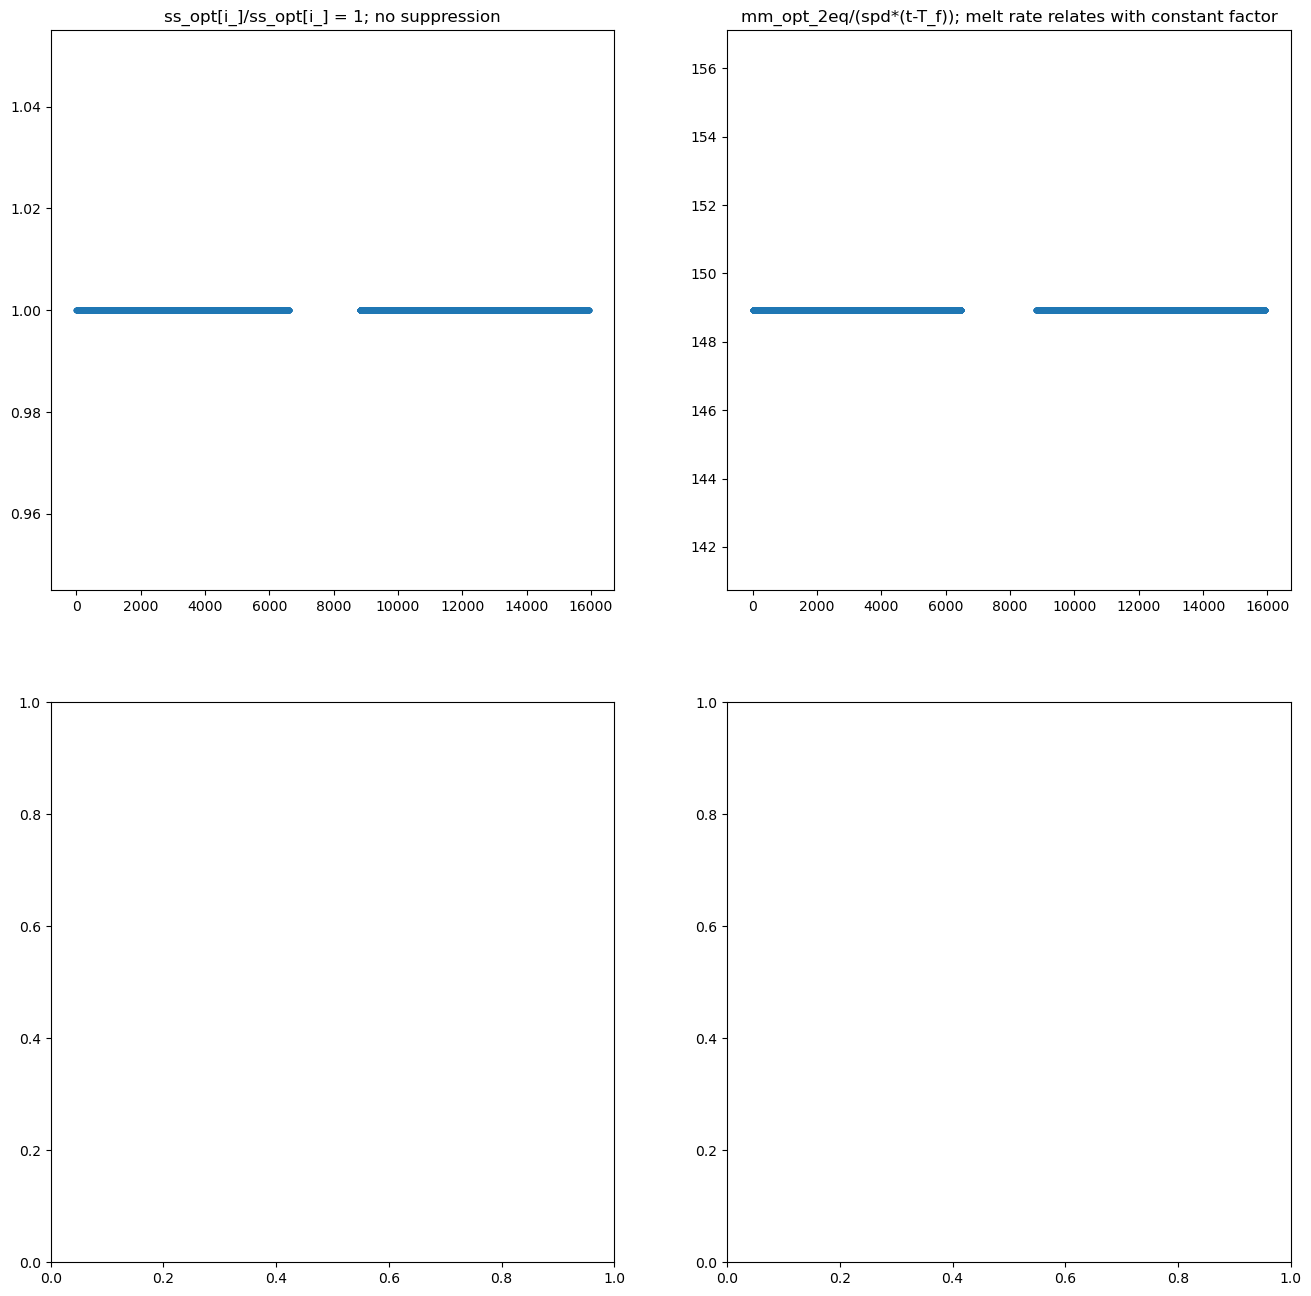

In [53]:
# compute melt rates based on long time series
mmf36_2eq = aa_2eq([t, spd, t/t],CdTts_opt_2eq)
mmf36_2eq_long = aa_2eq([tf36_full, spdf36_full, tf36_full/tf36_full],CdTts_opt_2eq)
mmf36_2eq_long_const_t = aa_2eq([tf36_full/tf36_full*np.nanmean(tf36_full), spdf36_full, tf36_full/tf36_full],CdTts_opt_2eq)
mmf36_2eq_long_const_spd = aa_2eq([tf36_full, spdf36_full/spdf36_full*np.nanmean(spdf36_full), tf36_full/tf36_full],CdTts_opt_2eq)

mmf36_3eq = aa_3eq([t, spd, t/t],CdTt_opt_3eq)
mmf36_3eq_long = aa_3eq([tf36_full, spdf36_full, tf36_full/tf36_full],CdTt_opt_3eq)
mmf36_3eq_long_const_t = aa_3eq([tf36_full/tf36_full*np.nanmean(tf36_full), spdf36_full, tf36_full/tf36_full],CdTt_opt_3eq)
mmf36_3eq_long_const_spd = aa_3eq([tf36_full, spdf36_full/spdf36_full*np.nanmean(spdf36_full), tf36_full/tf36_full],CdTt_opt_3eq)


T_f = (gamma_1*S_w + gamma_2 + gamma_3*Pb)
const = mmf36_2eq/(spd*(t-T_f))

print('T_f')
print(T_f)
print('CdTts_opt_2eq')
print(CdTts_opt_2eq)

fig, ax = plt.subplots(2,2, figsize=np.array([16,16]))
xy = [0,3.5]
ax[0,0].plot(t/t,'.')
ax[0,0].set_title('ss_opt[i_]/ss_opt[i_] = 1; no suppression')

ax[0,1].plot(const,'.')
ax[0,1].set_title('mm_opt_2eq/(spd*(t-T_f)); melt rate relates with constant factor')

In [ ]:
fig,ax=plt.subplots(3,1)
fig.set_figwidth(20)
fig.set_figheight(15)


ax[0].plot(num,mm,label="observations")
ax[0].plot(num,mm_opt_2eq,label="native 2-EQN")
ax[0].plot(num,mm_opt_3eq,label="native 3-EQN")
plt.sca(ax[0])
plt.axhline(y = 0, color = 'k', linestyle = '-')
plt.legend(loc="upper center")
ax[0].set_ylabel('ablation rate [m/yr]')
ax[0].set_xlim([736600, 738400])

ax[1].plot(num,mm,label="observations")
ax[1].plot(num_full,mmf36_2eq_long,label="native 2-EQN")
ax[1].plot(num_full,mmf36_2eq_long_const_spd,label="native 2-EQN, constant speed")
ax[1].plot(num_full,mmf36_2eq_long_const_t,label="native 2-EQN, constant temperature")
ax[1].plot(num_full,mmf36_3eq_long,label="native 3-EQN")
plt.sca(ax[1])
plt.axhline(y = 0, color = 'k', linestyle = '-')
plt.legend(loc="upper center")
ax[1].set_ylabel('ablation rate [m/yr]')
ax[0].set_xlim([736600, 738400])


#ax[0].plot(num_full,mm_opti_gampar_f36_full)
ax[2].plot(num,mm,label="observations")
ax[2].plot(num_full,mmf36_2eq_long,label="native 2-EQN full length")
ax[2].plot(num_full,mmf36_3eq_long,label="native 3-EQN full length")
# ax[1].plot(num,mmf36_2eq,label="short new")
# ax[1].plot(num,mm_opt_2eq,label="short control")
plt.sca(ax[2])
plt.axhline(y = 0, color = 'k', linestyle = '-')
plt.legend(loc="upper center")
ax[2].set_ylabel('ablation rate [m/yr]')

plt.savefig("../plot/melt_series_2eqn_long.png")
plt.show()


In [ ]:
print('Plot raw time sereies; FIXME: this plot needs to be mad properly')
fig,ax=plt.subplots(3,1)
fig.set_figwidth(20)
fig.set_figheight(15)
#ax[0].plot(num_full,mm_opti_gampar_f36_full)
ax[0].plot(num_full,mm_full,label="full")
ax[0].plot(num_full,mmf36_full)
ax[0].plot(num_full,mm_const_t,label="const t")
ax[0].plot(num_full,mm_const_spd,label="const spd")
ax[0].plot(num_full,mmf36_const_t,label="const t lp")
ax[0].plot(num_full,mmf36_const_spd,label="const spd lp")
plt.sca(ax[0])
plt.legend(loc="upper center")

ax[1].plot(num_full,spd_full)
ax[1].plot(num_full,spdf36_full)
ax[1].plot(num_full,spd_full/spd_full*np.nanmean(spd_full))
ax[2].plot(num_full,t_full)
ax[2].plot(num_full,tf36_full)
ax[2].plot(num_full,t_full/t_full*np.nanmean(t_full))
plt.savefig("../plot/melt_series_long.png")
plt.show()

In [ ]:
with h5py.File('m2_data.h5', 'w') as f:
    f.create_dataset('num', data=num_full)
    f.create_dataset('t', data=t_full)
    f.create_dataset('spd', data=spd_full)
    f.create_dataset('tf36', data=tf36_full)
    f.create_dataset('spdf36', data=spdf36_full)
    f.create_dataset('mm', data=mm_full)
    f.create_dataset('mmf36', data=mmf36_full)
    f.create_dataset('mm_const_t', data=mm_const_t)
    f.create_dataset('mmf36_const_t', data=mmf36_const_t)
    f.create_dataset('mm_const_spd', data=mm_const_spd)
    f.create_dataset('mmf36_const_spd', data=mmf36_const_spd)
    f.create_dataset('mmf36_2eq', data=mmf36_2eq_long)
    f.create_dataset('mmf36_2eq_const_t', data=mmf36_2eq_long_const_t)
    f.create_dataset('mmf36_2eq_const_spd', data=mmf36_2eq_long_const_spd)
    f.create_dataset('mmf36_3eq', data=mmf36_3eq_long)
    f.create_dataset('mmf36_3eq_const_t', data=mmf36_3eq_long_const_t)
    f.create_dataset('mmf36_3eq_const_spd', data=mmf36_3eq_long_const_spd)
    f.create_dataset('tfr', data=tfr)

A file with the data, full time sereis, has been saved. Therea are raw hourly series and 36h low-pass filtered series (*f36). melting has been obatined from regression with the optimized non-linear realtionship as described above and with the varying $\Gamma_T$ method. The data uses the native mooring time stamps. Probably the series need checking for gaps and/or large jumps in time which will sho up in the frequency space etc (see straight lines above).

Here is another dump of the shorter series, all interpolated on the ApRES tiem vector:

Text(0.5, 1.0, 'mm_opt_2eq/(spd*(t-T_f)); melt rate relates with constant factor')

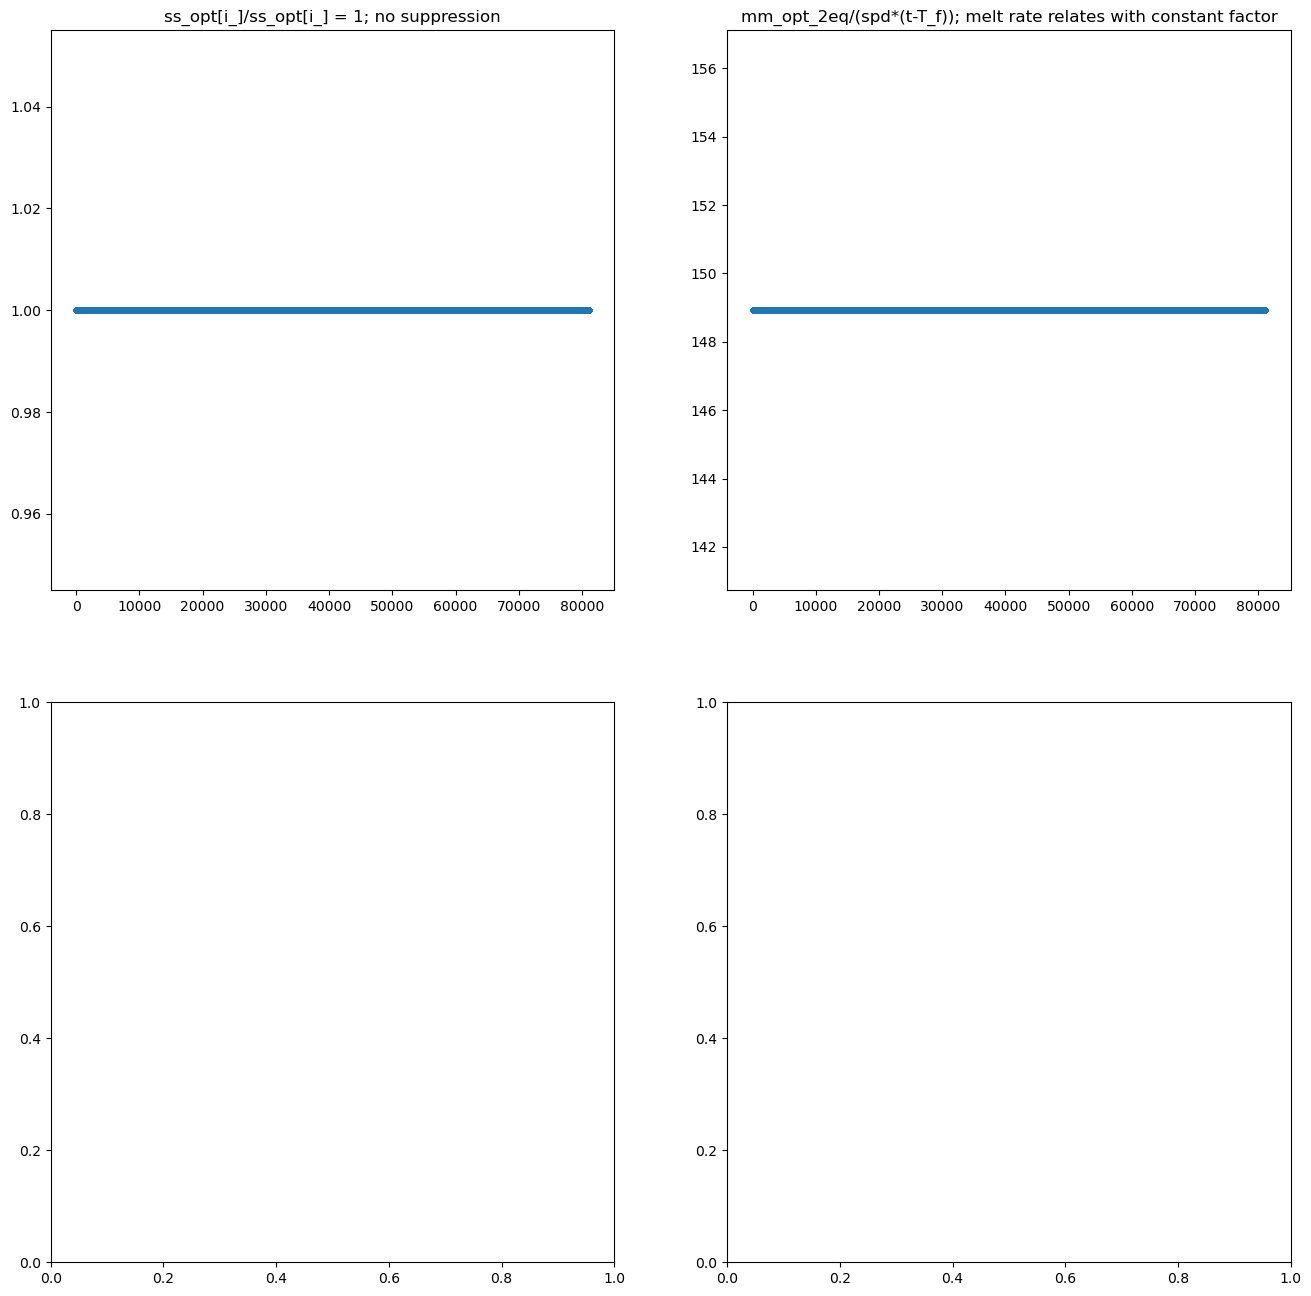

In [60]:
f1 = h5py.File('m2_data.h5','r+') 

list(f1.keys())

m_ver = np.array(f1['mmf36_2eq'])
t_ver = np.array(f1['tf36'])
spd_ver = np.array(f1['spdf36'])

#After you are done
f.close()

T_f = (gamma_1*S_w + gamma_2 + gamma_3*Pb)
const = m_ver/(spd_ver*(t_ver-T_f))

fig, ax = plt.subplots(2,2, figsize=np.array([16,16]))
xy = [0,3.5]
ax[0,0].plot(t_ver/t_ver,'.')
ax[0,0].set_title('ss_opt[i_]/ss_opt[i_] = 1; no suppression')

ax[0,1].plot(const,'.')
ax[0,1].set_title('mm_opt_2eq/(spd*(t-T_f)); melt rate relates with constant factor')

<u> Some loose thoughts on the relation of melt rates to ocean properties.</u>  
At zero order, ice ablation increases with larger ambient ocean temperature and velocity as both factors enhance the fluxes across the ice-ocean boundary layer. From the conservation of heat and salt, a quadratic equation for the ablation rate can be found that generally yields a non-linear response to changes in ambient thermal driving T* and friction velocity u* = C_d^(1/2)*U_0, while a linearized expression is obtained under the assumption of small variations of the salinity in the boundary layer.

THe time-varying strain and its trend would indicate a decreasing trend in melt rate that is not supported by the ocean observations. If the linear trend in the strain is related the ice dynamics of the basal channel, this may also affect the slope and hence the plume velocity, providing an explanation for a trend in melt rates that woudl not be observed as changes in ocean properties 30-40 m below the ice base where our mooring is situated. The discrepancy is, however, large, and the better fit of a constant mean strain with the ocean obs is encouraging. The offset in temperature/ thermal driving is still hard to explain (needing a temperature inversion below the ice base), casting doubt on the absolute magnitude of the observed (parameterized) melting (and strain). But later we found tht this probably connects to varying transfer coefficients


In [ ]:

# relevant for fitting 2d data
# https://scipython.com/blog/non-linear-least-squares-fitting-of-a-two-dimensional-data/

# fitting exponential to data
# https://stackoverflow.com/questions/3433486/how-to-do-exponential-and-logarithmic-curve-fitting-in-python-i-found-only-poly

# This is the callable that is passed to curve_fit. M is a (2,N) array
# where N is the total number of data points in Z, which will be ravelled

X, Y = np.meshgrid(uim,tdim)

# freezing point
tfr = (gamma_1*S_w + gamma_2 + gamma_3*Pb)

# Our function to fit:
def _inv_gamma(M, gamma0, slope0, slope2, expo, expo2):
    spd_in = M[0]
    t_in = M[1]
    # slope = (slope0 + slope2 * spd_in)**(1)
    # return 1/(gamma0 + slope * (t_in - tfr)**expo)
    gamma0_= gamma0 + slope2 * spd_in**1 #expo2
    return 1/(gamma0_ + slope0 * (t_in - tfr)**expo) #expo)


# Initial guesses to the fit parameters.
p0 = [(1/0.0011, 10, 1, 1, 1)]
# p0 = [(3, 0.5, 3, 0.5, 1, 1)]
# p0 = [5.15968711e+03, 3.86831714e+03, 6.15305094e+04,
#       5.50746068e-01, 1.00000000e+00]
p0 = [ 1.26314708e+00, -1.26305572e+00, -2.29257063e-03,  1.94445264e-04,
        1.00000000e+00]

iii = np.isfinite(gam)
spd_ = spd[ii]
t_ = t[ii]
popt, pcov = curve_fit(_inv_gamma, [spd_[iii], t_[iii]], 1/gam[iii], p0, maxfev = 12000)

gam_fun = 1/_inv_gamma([spd_,t_],popt[0],popt[1],popt[2],popt[3],popt[4])

fig, ax = plt.subplots(1,3, figsize=np.array([18, 6]))
ax[0].plot(gam_fun,gam,'.')
ax[0].plot([0, 0.002],[0, 0.002])

# 2 D fit
# We need to ravel the meshgrids of X, Y points to a pair of 1-D arrays.
# xdata = np.vstack((X.ravel(), Y.ravel()))
# Do the fit, using our custom _gaussian function which understands our
# flattened (ravelled) ordering of the data points.
# popt, pcov = curve_fit(_inv_gamma, xdata, 1/gam.ravel(), p0)

#########
#scipy.optimize.curve_fit(lambda t,a,b: a*numpy.exp(b*t),  x,  y,  p0=(4, 0.1))

# import numpy as np
# import matplotlib.pyplot as plt
# from scipy.optimize import curve_fit
# 
# def func(x, a, b, c):
#     return a * np.exp(-b * x) + c
#
# x = np.linspace(0,4,50)
# y = func(x, 2.5, 1.3, 0.5)
# yn = y + 0.2*np.random.normal(size=len(x))
#
# popt, pcov = curve_fit(func, x, yn)